take sweeps with ZI and move across the beam

In [1]:
# python scientific programming modules
import matplotlib.pyplot as plt
#from matplotlib import gridspec
import matplotlib.patches as patches
#from scipy.signal import argrelmax
import numpy as np
import seaborn as sns
#sns.set_context("talk")
sns.set_style("dark")

# python misc
from os import listdir
from os.path import isfile, join
%matplotlib inline
#import threading
import json
import time

# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')

# hardware interface modules
import hardware_modules.ZiControl as zi
import hardware_modules.PhotodiodeInput as PDIn
import hardware_modules.PiezoController as pc
import functions.ScanPhotodiode_DAQ as galvo_scan
from  hardware_modules.GalvoMirrors import SetGalvoPoint
# from  hardware_modules.PhotodiodeInput import ReadPhotodiode


#custom helper module
import functions.tracking as track


# file = './2015-05-21_20-32-29-5.8e-4Torr_NoPinhole_R100k.csv'
# folder = './'

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

DIR_PATH = 'Z:/Lab/Cantilever/Measurements/20150709_Diamond_Ramp_Over_Mags_heat_Magnets/'
TAG = 'Si3N4'

363.8283426


#Visualization Helper Functions

In [2]:
def add_colorbar(fig, images, colorbar_lims, title='Photodiode Amplified Voltage [V]'):
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for image in images:
        image.set_clim(colorbar_lims)
        cbar = fig.colorbar(image, cax=cbar_ax, ticks = colorbar_lims)

    cbar.set_label(title)
    return fig



def display_image(axes, image_data_scaled, extent, title='Image'):
    image = axes.imshow(image_data_scaled, extent=extent, 
               interpolation = 'none', cmap = 'RdYlBu', aspect='auto', origin='lower');

    axes.set_title(title)
    axes.set(aspect=1)
    axes.set_xlabel('x Voltage [V]')
    axes.set_ylabel('y Voltage [V]')
    
    return image


def display_image_and_roi(whole_image_data, extent, roi, colorbar_lims='None'):
    
    if colorbar_lims:
        whole_image_data = np.clip(whole_image_data, colorbar_lims[0], colorbar_lims[1])

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False);
    
    # Add image of whole area
    whole_image = display_image(axes[0], whole_image_data, extent, title='Full Image')

    # Add rectangle of region of interest
    axes[0].add_patch(patches.Rectangle( (ROI['xo'] - ROI['dx']/2.0, ROI['yo'] - ROI['dy']/2.0), 
                                         width=ROI['dx'], 
                                         height=ROI['dy'], 
                                         fill=False, edgecolor='w', linewidth=1));

    # Add blown up region of interest image
    roi_image = display_image(axes[1], whole_image_data, extent, title='Region of Interest (RoI)')
    #Zoom into area of interest
    xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(roi)
    axes[1].set_xlim([xVmin, xVmax])
    axes[1].set_ylim([yVmin, yVmax])
    
    fig = add_colorbar(fig, [whole_image, roi_image], colorbar_lims)
    
    return fig, axes




def get_points_along_line(pos1, pos2, xpts):
    dx = 1.*(pos2[0] - pos1[0]) / (xpts - 1)
    dy = 1.*(pos2[1] - pos1[1]) / (xpts - 1)
    print dx, dy
    xy = np.zeros([xpts, 2])
    
    for i in np.arange(xpts):
        xy[i] = pos1[0] + 1.*i * dx, pos1[1] + i * dy
    return xy
    

# Full Area Parameters

In [3]:
start_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
filename = '{:s}_{:s}'.format(start_time,TAG) 

In [4]:
# =============================================
# =============================================
# set the initial scan range
# =============================================


WHOLE_IMAGE = {
        "xo": 0, 'yo': 0,
        "dx": 1, 'dy': 1,
        'xPts': 101, 'yPts': 101
    }


xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(WHOLE_IMAGE)
TIME_PER_PT = 0.002


#Take Scan of Full Area, Save it

In [108]:
scanner = galvo_scan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts, TIME_PER_PT, canvas = None)
image_data = scanner.scan()

np.savetxt(DIR_PATH + 'image.csv', image_data, delimiter = ',')

np.savetxt('{:s}/{:s}_overview_image.csv'.format(DIR_PATH, filename), image_data, delimiter = ',')

#Load Previous Image

In [109]:
# DIR_PATH = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/MoveFocusAndChangePower/'
# image_data = np.loadtxt('{:s}/{:s}_overview_image.csv'.format(DIR_PATH, filename), delimiter = ',')

# set RoI

In [154]:
# =============================================
# =============================================
# display image 
# =============================================

# ---------------------------------------------
# adjust the color scale
CLIM_MIN, CLIM_MAX = -0.02, 0
# ---------------------------------------------

# ---------------------------------------------
# set region of interest

# roi = {
#         "xo": -0.037, 'yo': 0.165,
#         "dx": 0.1, 'dy': 0.2,
#         'xPts': 30, 'yPts': 60
#     }



#Visualize Image and ROI

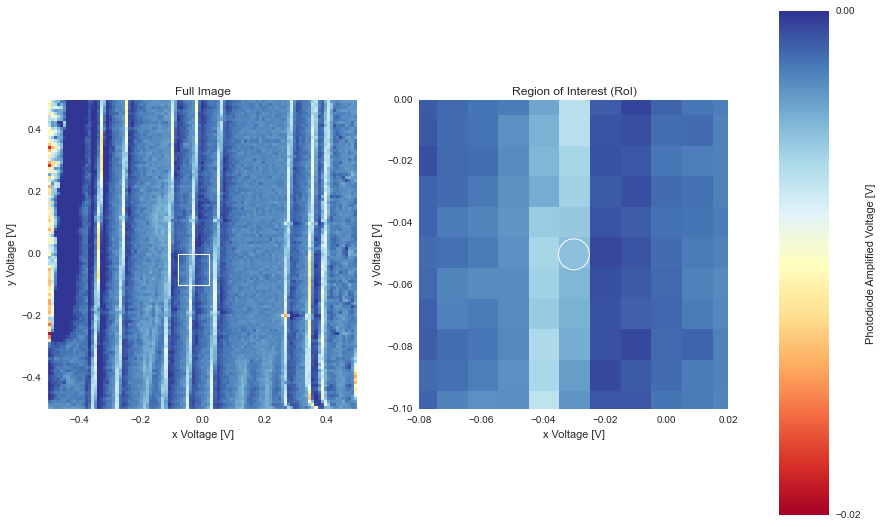

In [169]:

ROI = {
        "xo": -0.03, 'yo': -0.05,
        "dx": 0.1, 'dy': 0.1,
        'xPts': 40, 'yPts': 40
    }



xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(WHOLE_IMAGE)
extent = [xVmin, xVmax, yVmin, yVmax]


fig, axes = display_image_and_roi(image_data, extent, ROI, [CLIM_MIN, CLIM_MAX])

#Add area we will scan over

#axes[1].add_patch(patches.FancyArrowowowPatch(posA=(0.105, 0.19), posB=(0.125, 0.19), 
#                                          arrowstyle='<->'));

axes[1].add_patch(patches.Circle(xy=(ROI['xo'], ROI['yo']), radius=.005, fill=False, edgecolor='w', linewidth=1))

0.00285714285714 0.0


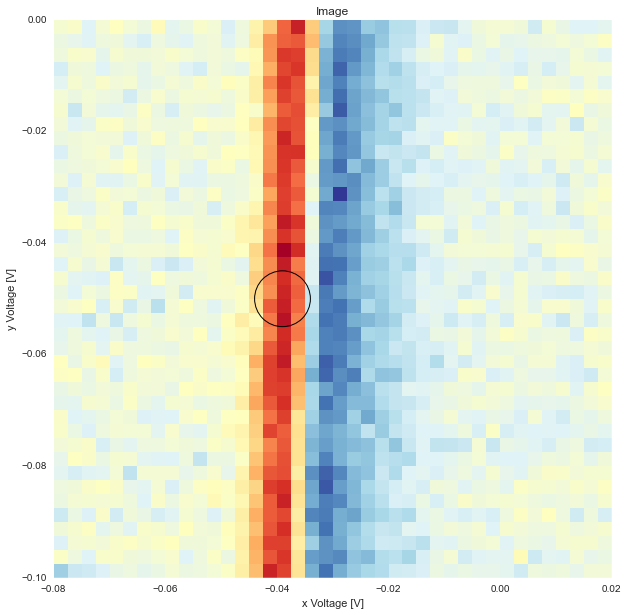

In [119]:


# ROI = {
#         "xo": 0.19, 'yo': 0.14,
#         "dx": 0.1, 'dy': 0.20,
#         'xPts': 40, 'yPts': 80,
#         'x_laser': 0.195, 'y_laser': 0.125
#     }
ROI.update({'x_laser': -0.039, 'y_laser': -0.05})

xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(ROI)

scanner = galvo_scan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts, TIME_PER_PT, canvas = None)
# roi_image_data = scanner.scan()

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=False);
display_image(axes, roi_image_data, [xVmin, xVmax, yVmin, yVmax], title='Image')
# fig.show()

# axes.add_patch(patches.Circle(xy=(ROI['xo'], ROI['yo']), radius=.005, fill=False, edgecolor='w', linewidth=1))
axes.add_patch(patches.Circle(xy=(ROI['x_laser'], ROI['y_laser']), radius=.005, fill=False, edgecolor='k', linewidth=1))






# for xy in line1:
#         axes.add_patch(patches.Circle(xy=(xy[0], xy[1]), radius=.001, fill=True, edgecolor='k', linewidth=1))

        
# line1 = get_points_along_line([0.01,-0.05], [0.21,-0.05], 50)

# line2 = get_points_along_line([0.01,-0.19], [0.21,-0.19], 50)

line1 = get_points_along_line([0.14,-0.05], [0.18,-0.05], 15)

line = np.concatenate((line1, line2), axis = 0)
for line in [line1]:
    for xy in line:
            axes.add_patch(patches.Circle(xy=(xy[0], xy[1]), radius=.001, fill=True, edgecolor='k', linewidth=1))
# x_offsets = np.linspace(-0.1,0.09, 45)
# y_offsets = np.linspace(-0.135,0, 5) 
# y_offsets = np.array([-0.135,-0.06,0, 0.16]) 



# for y_offset in y_offsets:
#     for x_offset in x_offsets:
#         axes.add_patch(patches.Circle(xy=(ROI['xo'] + x_offset, ROI['yo']+ y_offset), radius=.001, fill=True, edgecolor='r', linewidth=1))

In [120]:
SetGalvoPoint(ROI['x_laser'], ROI['y_laser']) 

<hardware_modules.GalvoMirrors.SetGalvoPoint instance at 0x000000002D6D9288>

In [275]:
Fo = 1.940e6
dF = 50e3
sampleNum = 5e3 +1
Fo - dF/2, Fo + dF/2, dF / (sampleNum-1)

(1915000.0, 1965000.0, 10.0)

In [276]:
filename

'2015-06-08_14-47-08_Si3N4'

#  loop over different xo positions, don't correct for drifts

In [27]:
# Fo = 1.94065e6
# dF = 1800.


# start_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
# filename = '{:s}_{:s}'.format(start_time,TAG) 

# ========================================================================================


AMPLITUDE = 1


zi_parameter = {
    'amplitude' : AMPLITUDE,
    'offset' : AMPLITUDE + 1,
    'freq' : 1e5,
    'ACCoupling' : 0, 
    'inChannel' : 0,
    'outChannel' : 0,
    'auxChannel': 0,
    'add' : 1,
    'range' : 10**int(np.ceil(np.log10(AMPLITUDE)))
}


with open('{:s}.zi'.format('{:s}/{:s}'.format(DIR_PATH, filename)), 'w') as outfile:
    json.dump(zi_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
zi_hf2 = zi.ZIHF2(**zi_parameter)
        

autoConnect connected to a server on port 8005 using API level 1.
autoDetect selected the device dev35 for the measurement.
[['/dev35/sigins/0/imp50', 1], ['/dev35/sigins/0/ac', 0], ['/dev35/sigins/0/range', 2], ['/dev35/demods/0/order', 4], ['/dev35/demods/0/rate', 10000.0], ['/dev35/demods/0/harmonic', 1], ['/dev35/demods/0/phaseshift', 0], ['/dev35/sigouts/0/on', 1], ['/dev35/sigouts/0/range', 1], ['/dev35/sigouts/0/enables/6', 1], ['/dev35/sigouts/0/amplitudes/6', 1.0], ['/dev35/AUXOUTS/0/OFFSET', 2], ['/dev35/oscs/0/freq', 100000.0], ['/dev35/demods/0/oscselect', 0], ['/dev35/demods/0/adcselect', 0], ['/dev35/sigins/0/diff', 0], ['/dev35/sigouts/0/add', 1]]


In [142]:
2e3/4e2

5.0

2015-06-11 17:45:29
current laser position: 0.140V,  -0.050V
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-11 17:48:03
current laser position: 0.143V,  -0.050V
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-11 17:50:37
current laser position: 0.146V,  -0.050V
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-11 17:53:12
current laser position: 0.149V,  -0.050V
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-11 17:55:47
current laser position: 0.151V,  -0.050V
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-11 17:58:24
current laser position: 0.154V,  -0.050V
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-11 18:00:59
current laser position: 0.157V,  -0.050V
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-11 18:03:32
current laser position: 0.160V,  -0.050V


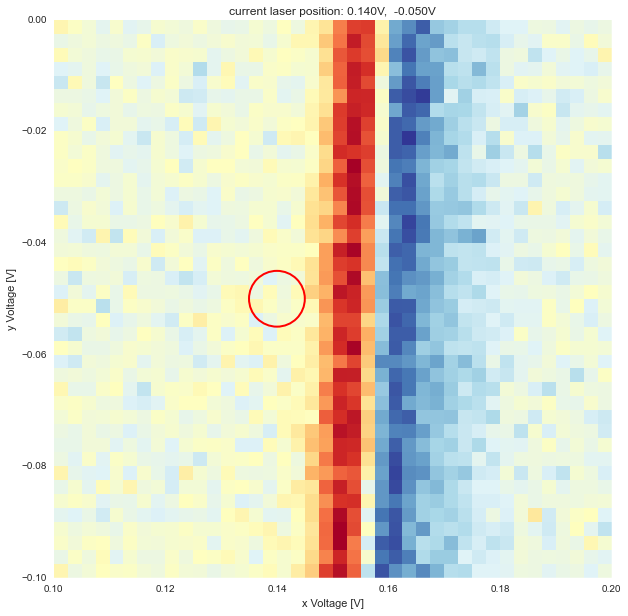

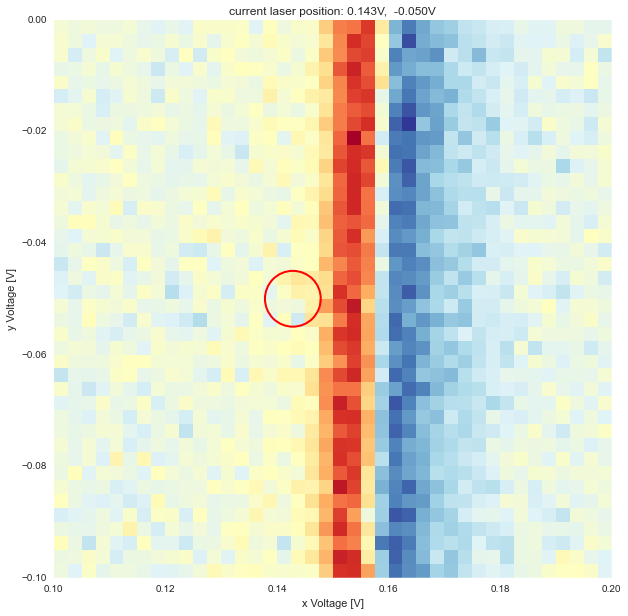

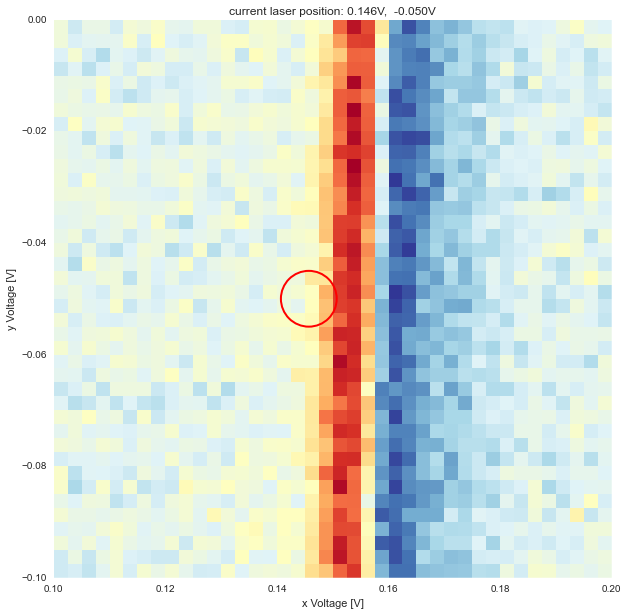

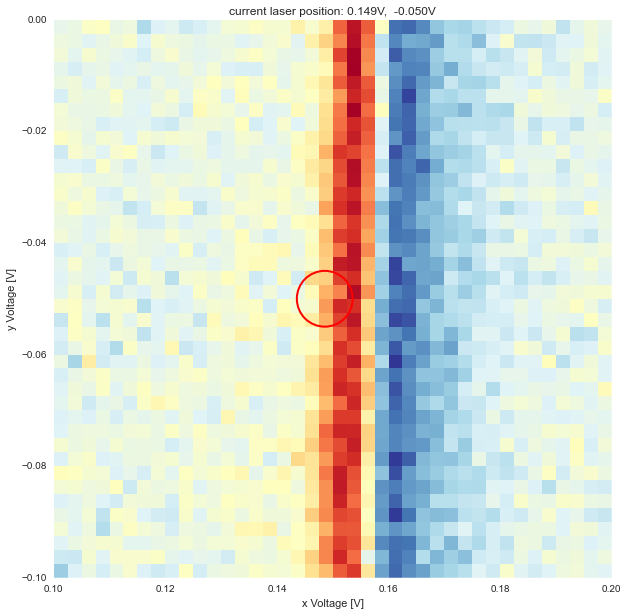

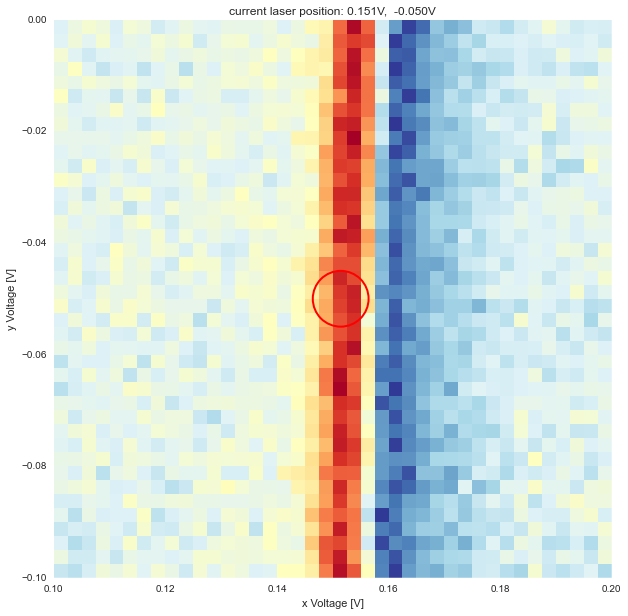

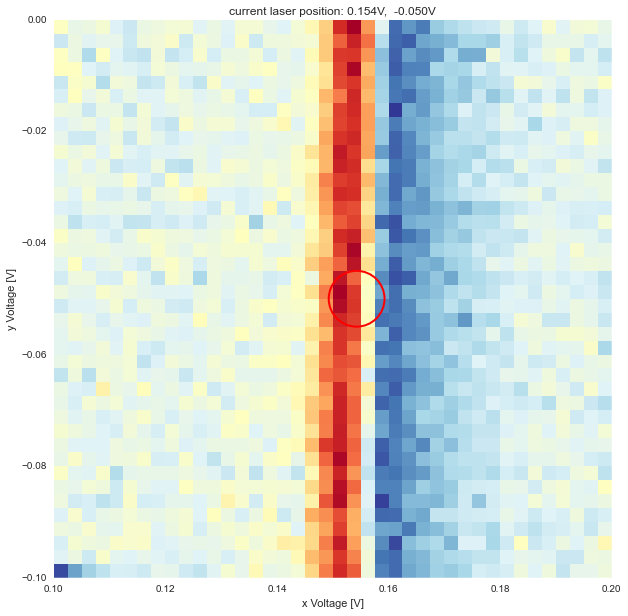

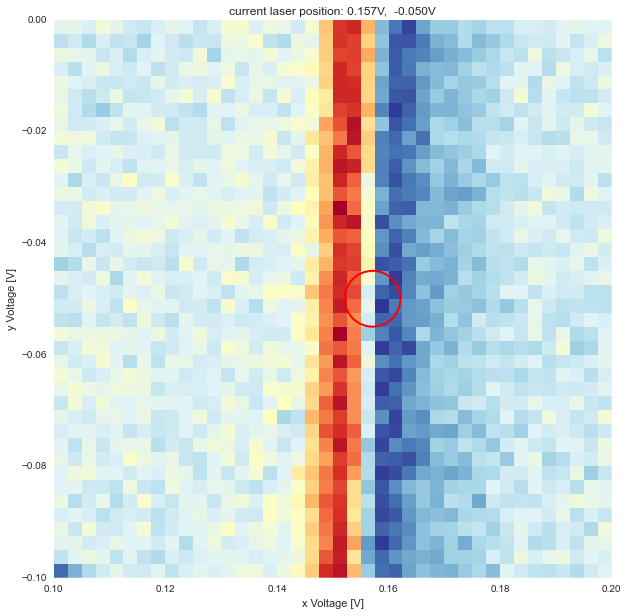

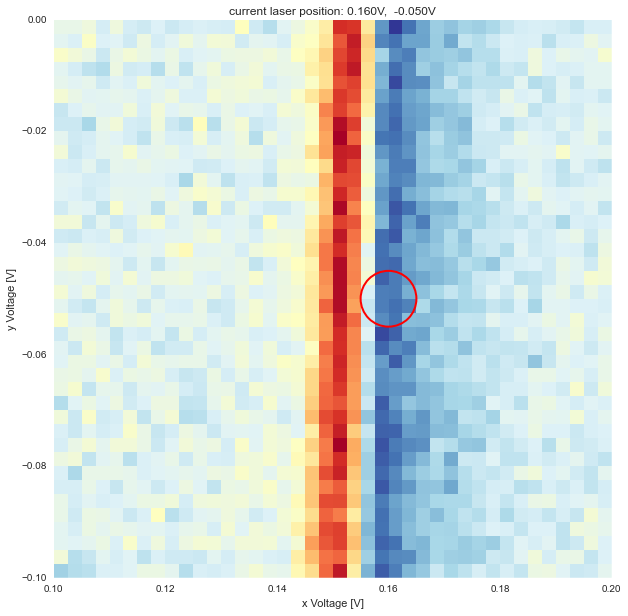

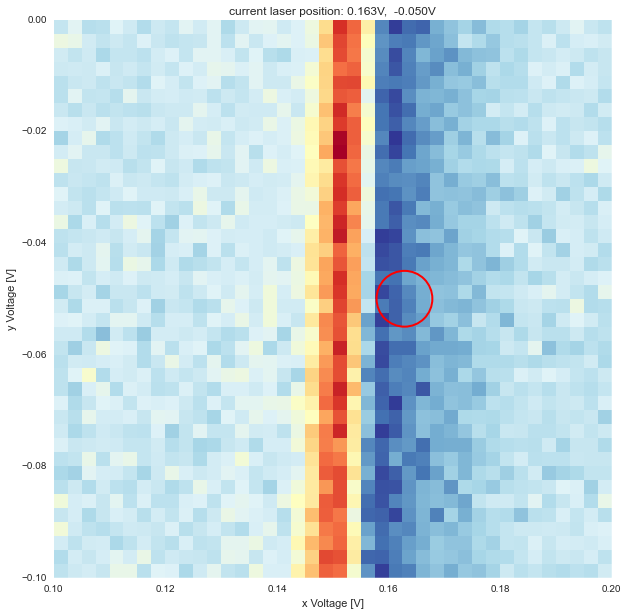

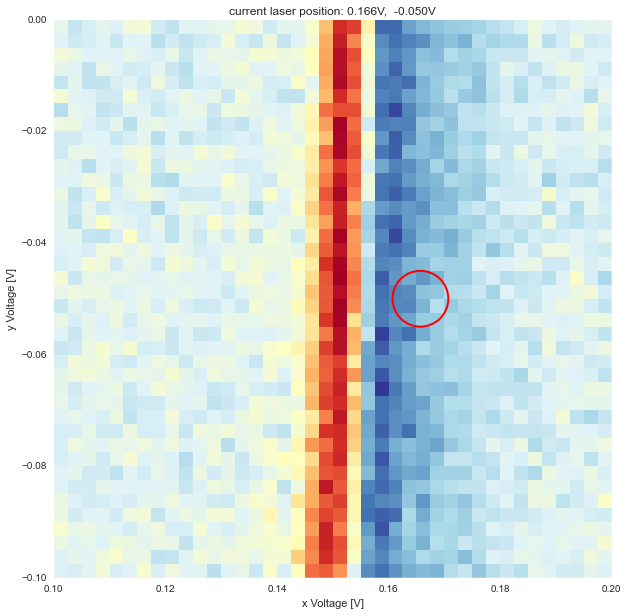

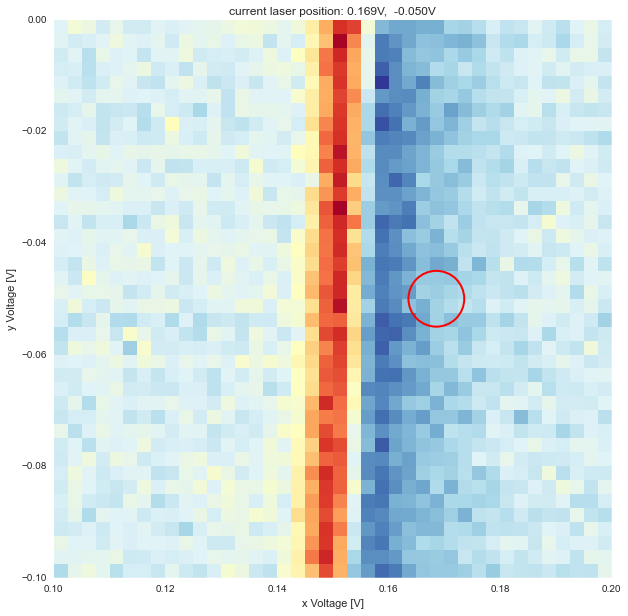

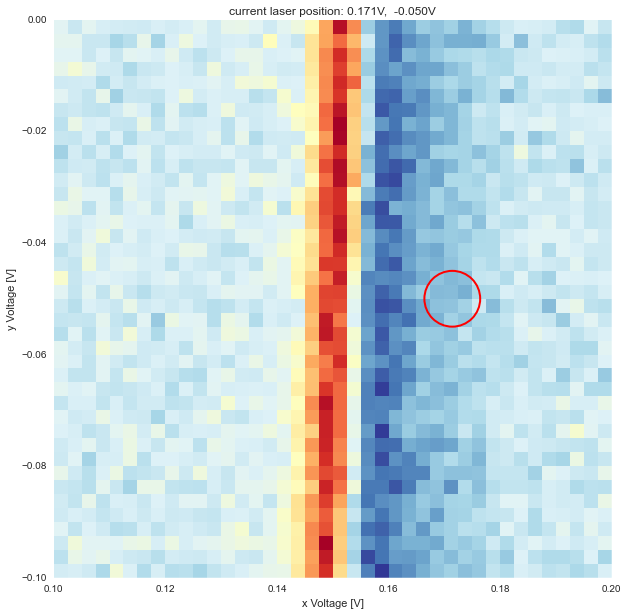

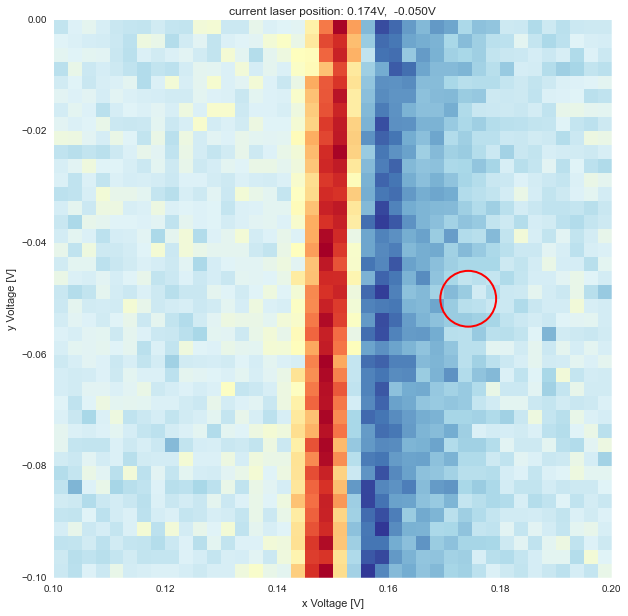

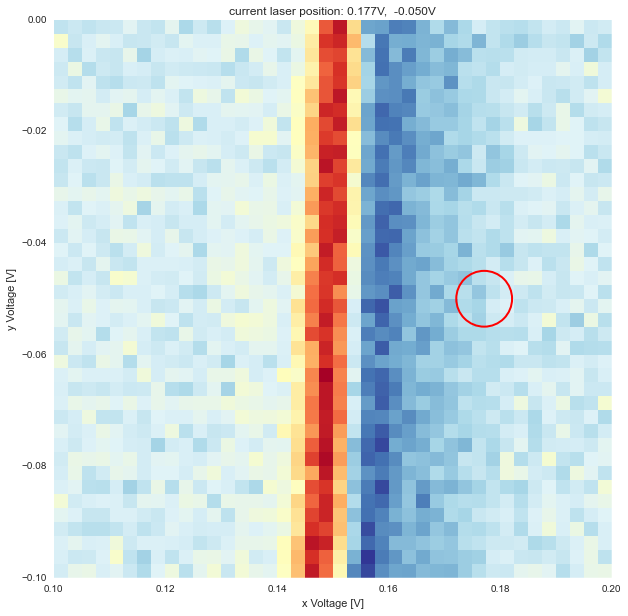

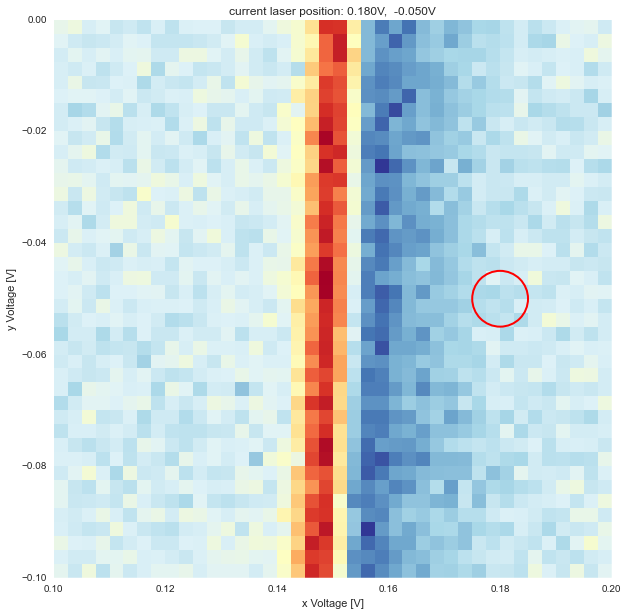

In [37]:

# Fo_array = [1920e3, 1930e3, 1940e3, 1950e3, 1960e3, 1910e3, 1900e3, 1890e3]
Fo_array = [1934.5e3]
dF = 2e3

sampleNum = 4e2+1
for Fo in Fo_array:

    start_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    filename = '{:s}_{:s}'.format(start_time,TAG) 



    # define new interval for sweep 
    sweep_parameter = {
        'freqStart' : Fo - dF/2.,
        'freqEnd' : Fo + dF/2.,
        'sampleNum' : sampleNum,
        'samplesPerPt' : 4, 
        'xScale' : 0,
        'direction' : 0,
        'loopcount': 1,
        'timeout' : 1e8
    }


    with open('{:s}.sweep'.format('{:s}/{:s}'.format(DIR_PATH, filename)), 'w') as outfile:
        json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


for line in [line1]:
    for xy in line:

    #     for y_offset in y_offsets:
    #         for x_offset in x_offsets:
            print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

            ROI.update({'x_laser':xy[0], 'y_laser': xy[1]})
    #         ROI.update({'x_laser': ROI['xo'] + x_offset, 'y_laser': ROI['yo']+ y_offset})

            full_filename = '{:s}/{:s}_Fo_{:00.3f}_xL_{:00.3f}_xL_{:00.3f}V'.format(DIR_PATH, filename, Fo*1e-3,  ROI['x_laser'], ROI['y_laser'])


            print 'current laser position: {:00.3f}V,  {:00.3f}V'.format(ROI['x_laser'], ROI['y_laser'])

            # ---------------------------------------------
            # scan ROI
            xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(ROI)

            scanner = galvo_scan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts, TIME_PER_PT, canvas = None)
            roi_image_data = scanner.scan()

            fig_RoI, axes = plt.subplots(nrows=1, ncols=1, sharey=False);
            display_image(axes, roi_image_data, [xVmin, xVmax, yVmin, yVmax], title='current laser position: {:00.3f}V,  {:00.3f}V'.format(ROI['x_laser'], ROI['y_laser']))

            axes.add_patch(patches.Circle(xy=(ROI['x_laser'], ROI['y_laser']), radius=.005, fill=False, edgecolor='r', linewidth=2))

            fig_RoI.savefig('{:s}.png'.format(full_filename))
            np.savetxt('{:s}.csv'.format(full_filename), roi_image_data, fmt='%.18e', delimiter=',')

            with open('{:s}.roi'.format(full_filename), 'w') as outfile:
                 json.dump(ROI, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


            # ========================================================================================
            # set laser position
            SetGalvoPoint(ROI['x_laser'], ROI['y_laser']) 

            # ========================================================================================
            # look for mechanical resonance and save sweep data

            zi_hf2.sweep(**sweep_parameter)

            zi_hf2.writeData('{:s}.dat'.format(full_filename))



# measure over time

In [79]:
# import time
# print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#  # delays for 5 seconds
# print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


# DIR_PATH = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Beam5_Time_stability_0.6mW_7h/'


2015-06-11 20:37:47
2015-06-11 20:37:47


In [121]:

# Fo_array = [1920e3, 1930e3, 1940e3, 1950e3, 1960e3, 1910e3, 1900e3, 1890e3]
Fo_array = [1935e3]
dF = 12e3

sampleNum = 24e2+1

start_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
filename = '{:s}_{:s}'.format(start_time,TAG) 



# define new interval for sweep 
sweep_parameter = {
    'freqStart' : Fo - dF/2.,
    'freqEnd' : Fo + dF/2.,
    'sampleNum' : sampleNum,
    'samplesPerPt' : 4, 
    'xScale' : 0,
    'direction' : 0,
    'loopcount': 1,
    'timeout' : 1e8
}
dF / (sampleNum-1)

5.0

2015-06-12 11:59:27
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-12 12:21:47
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-12 12:44:08
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-12 13:06:30
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-12 13:28:42
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 13:50:48
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 14:12:36
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 14:34:26
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 14:56:36
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 15:18:34
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-12 15:40:42
Will perform 1 sweeps....

sample cont

C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


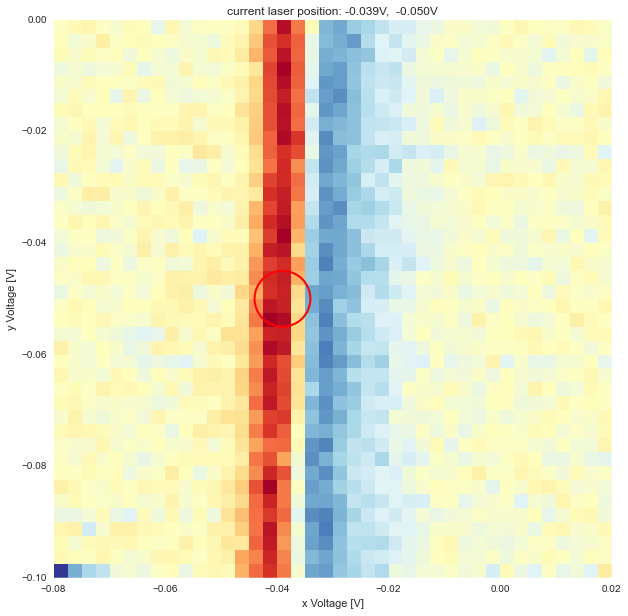

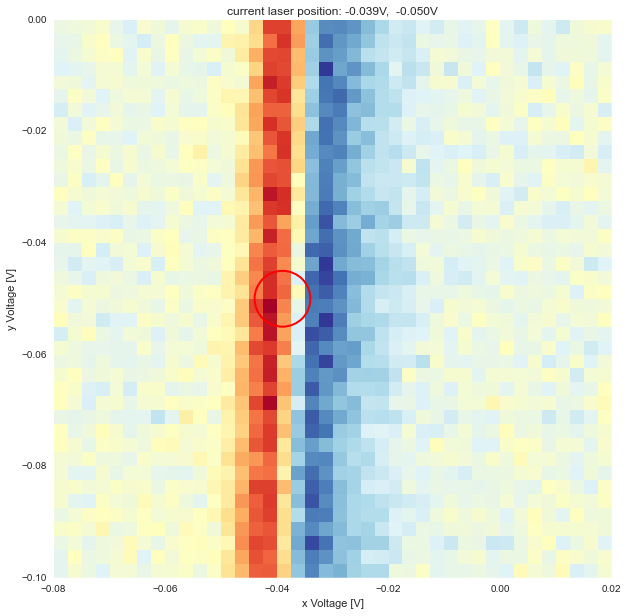

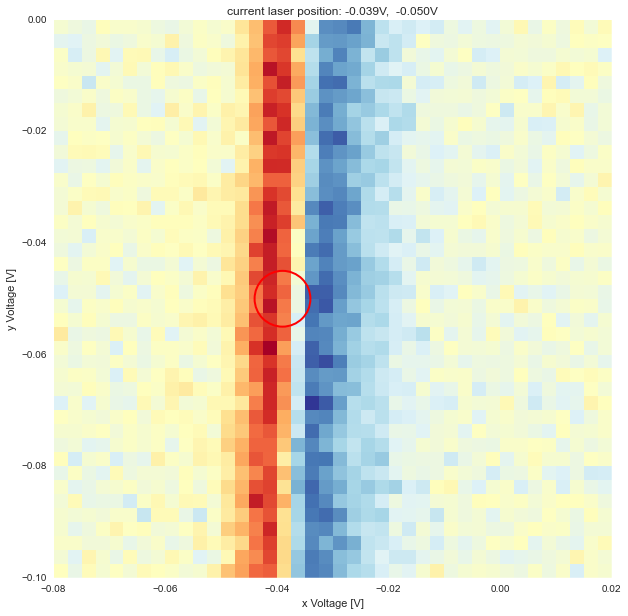

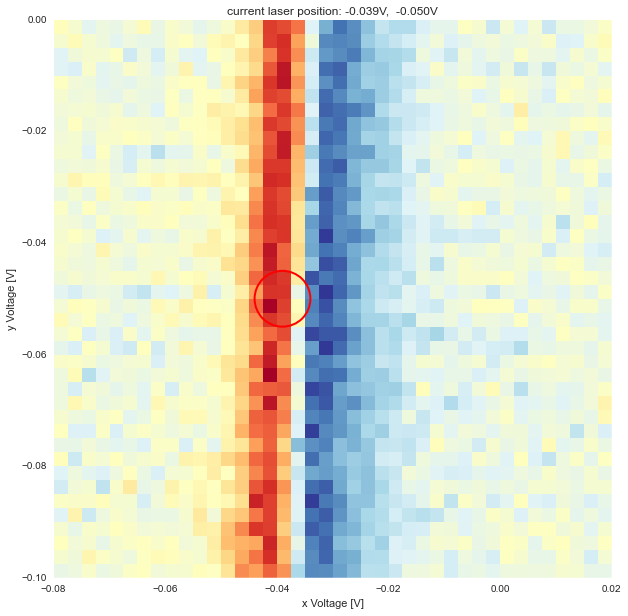

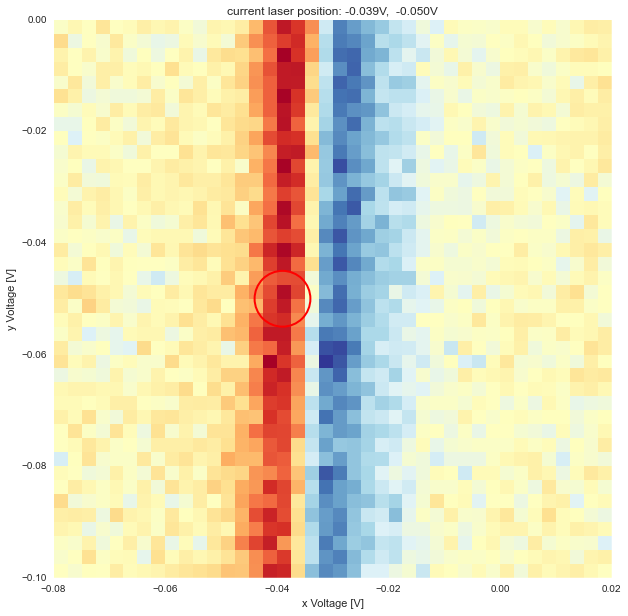

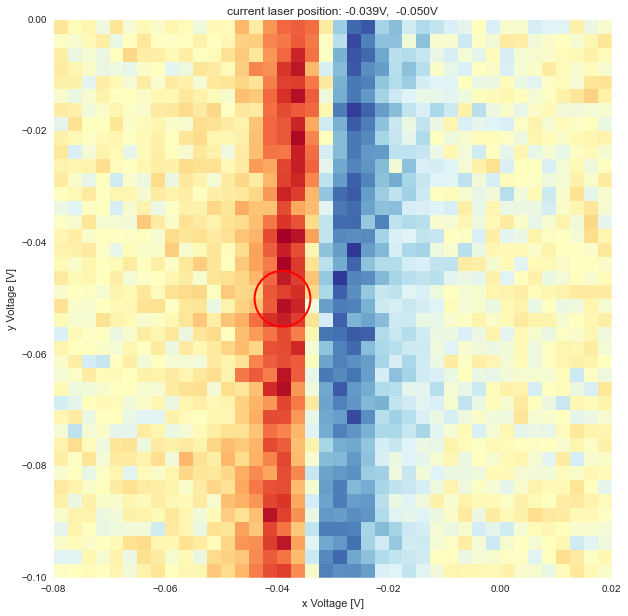

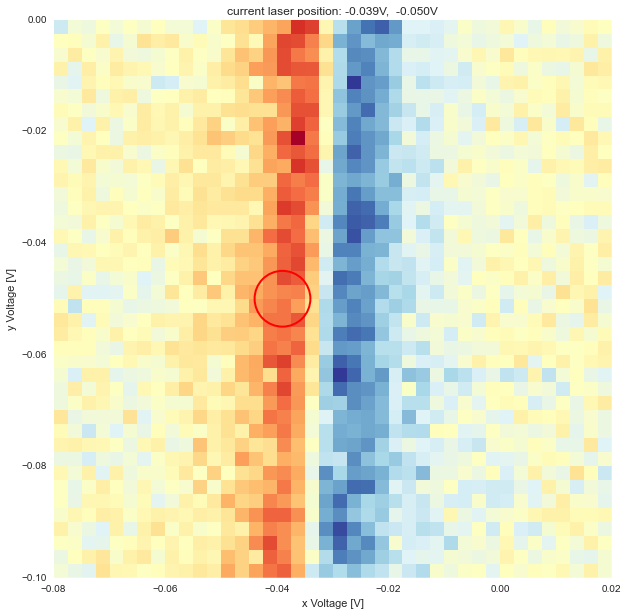

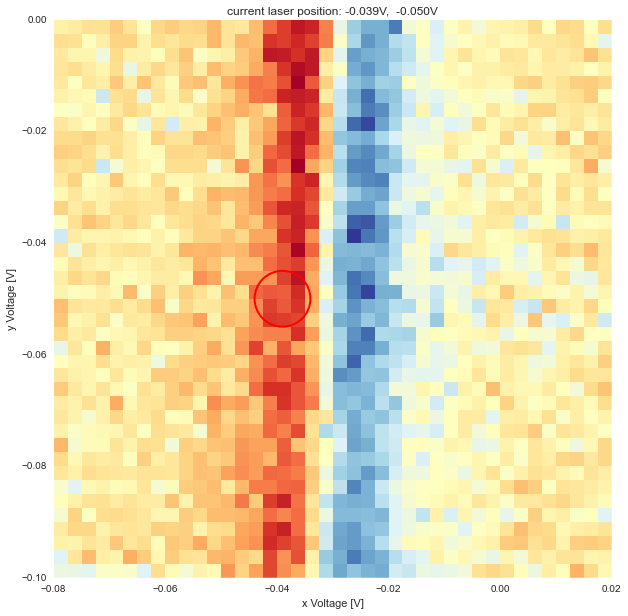

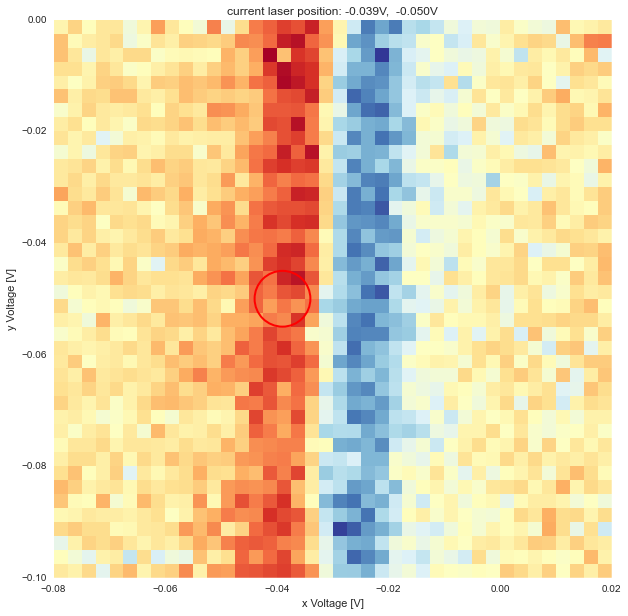

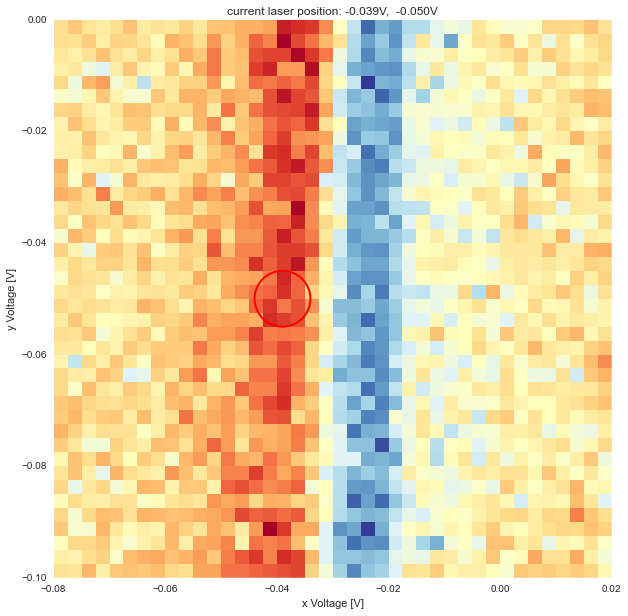

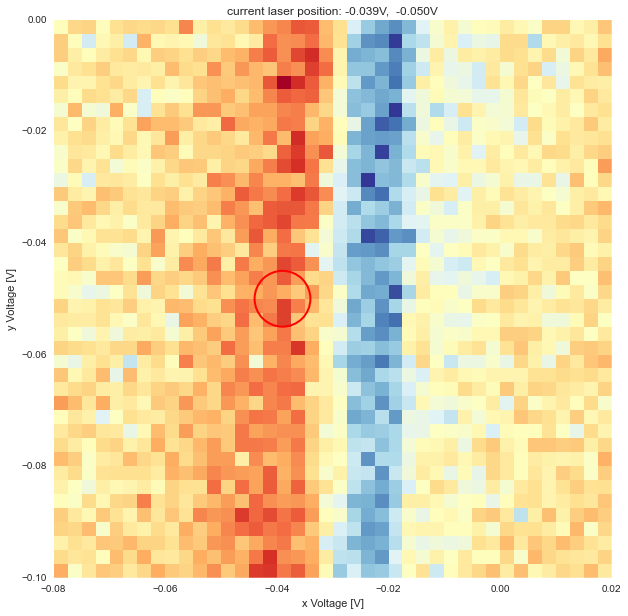

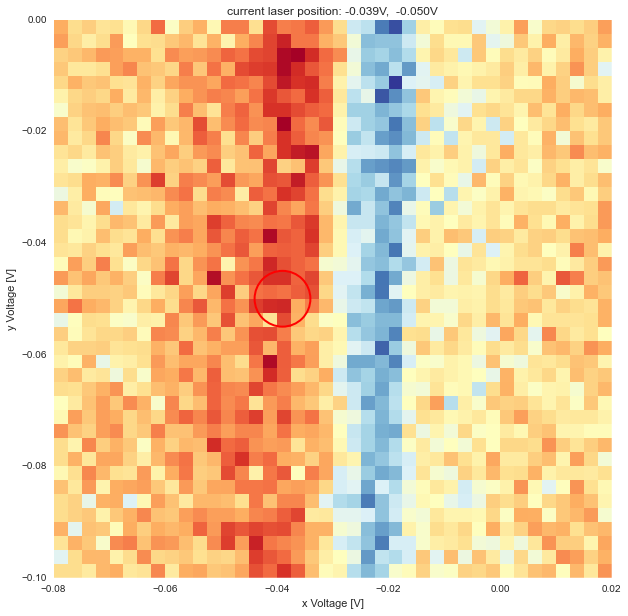

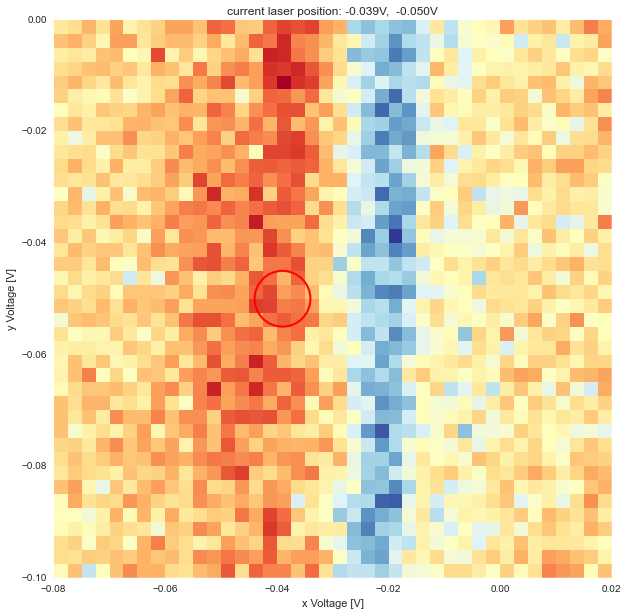

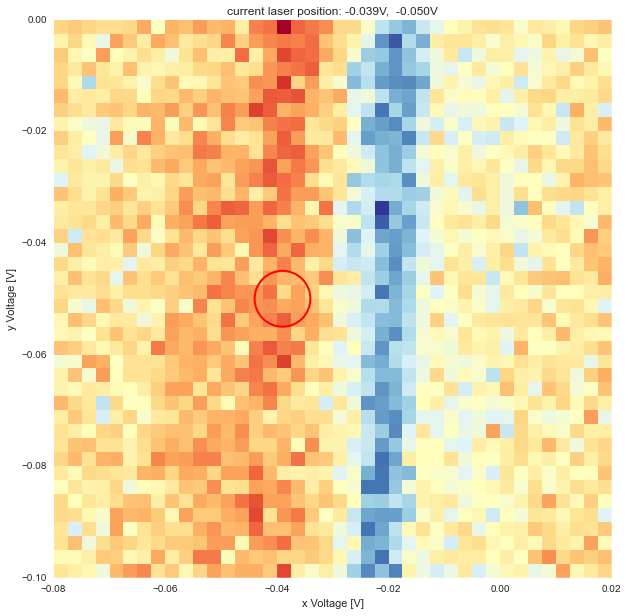

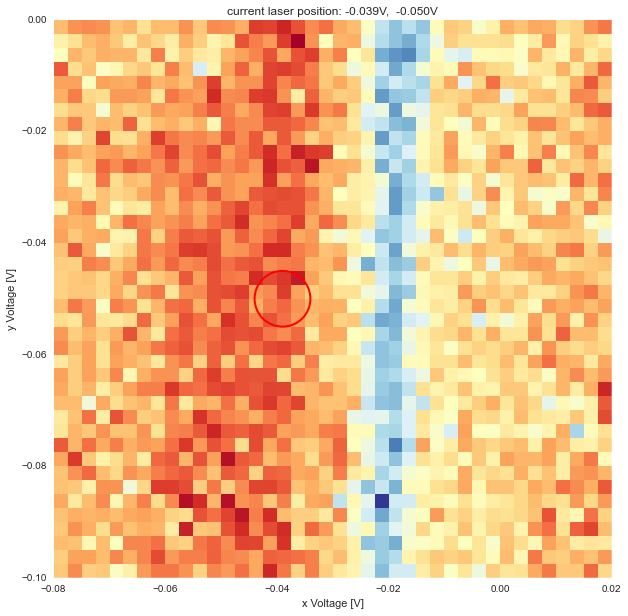

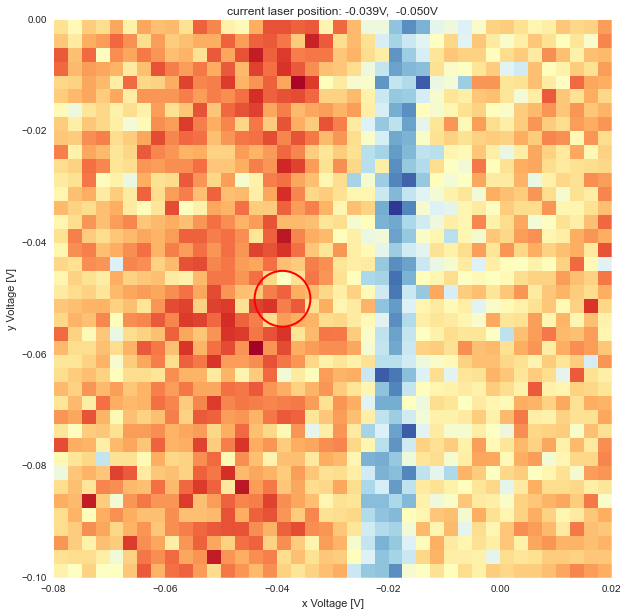

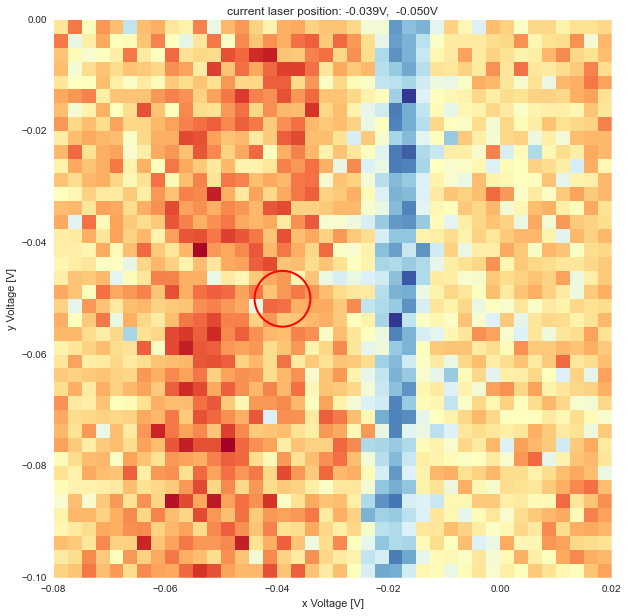

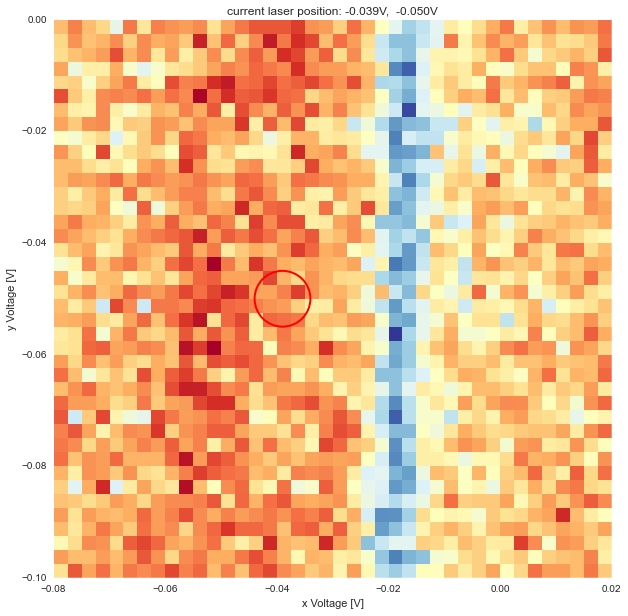

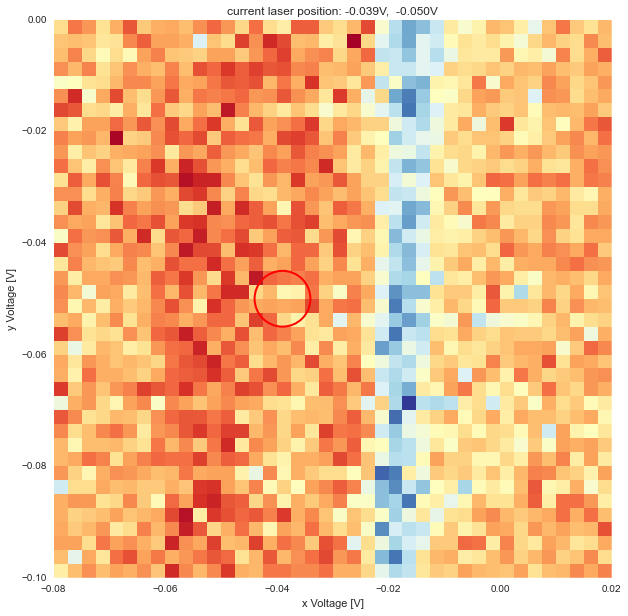

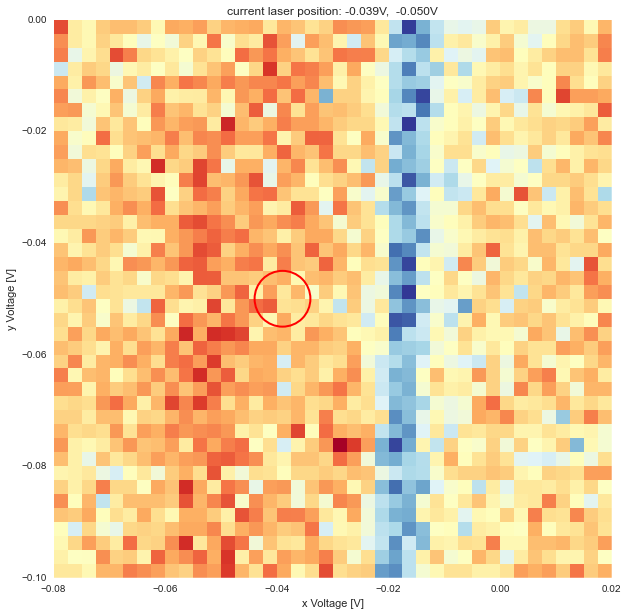

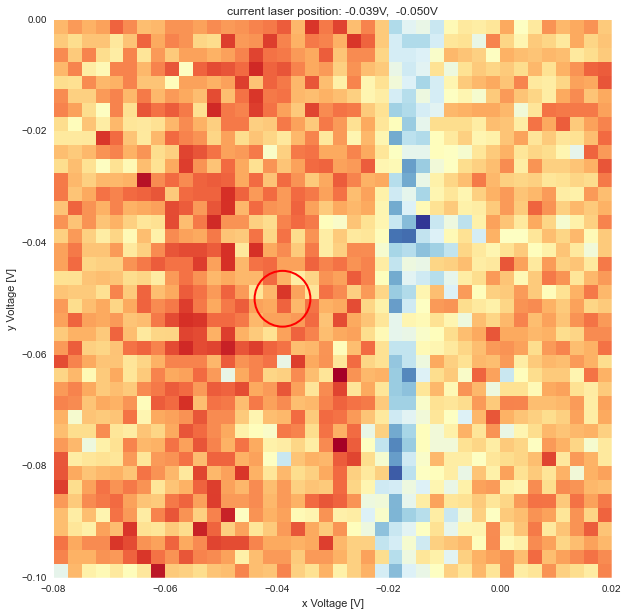

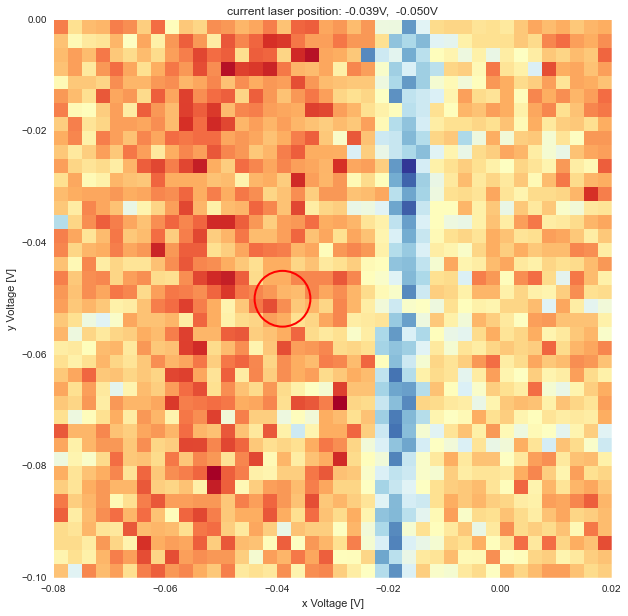

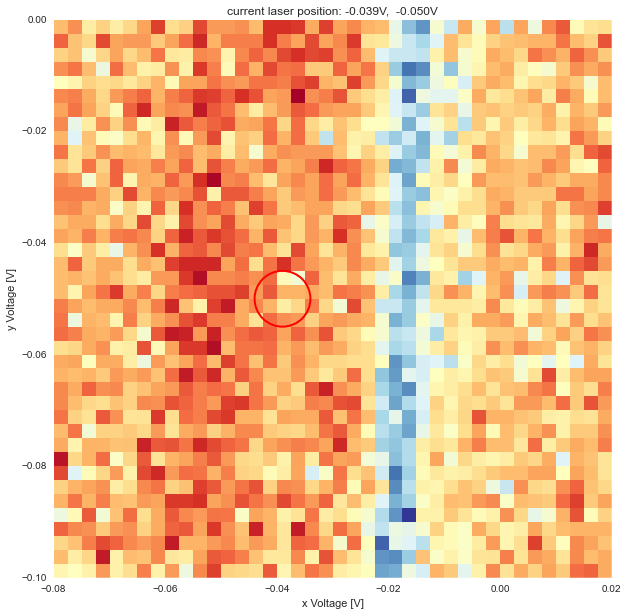

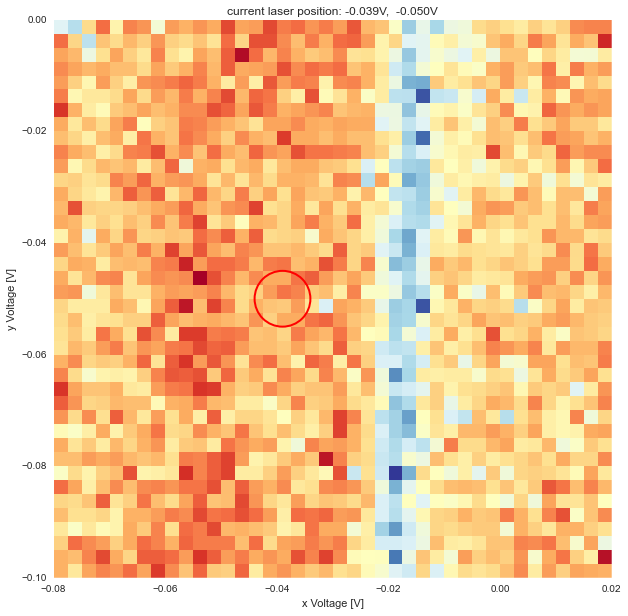

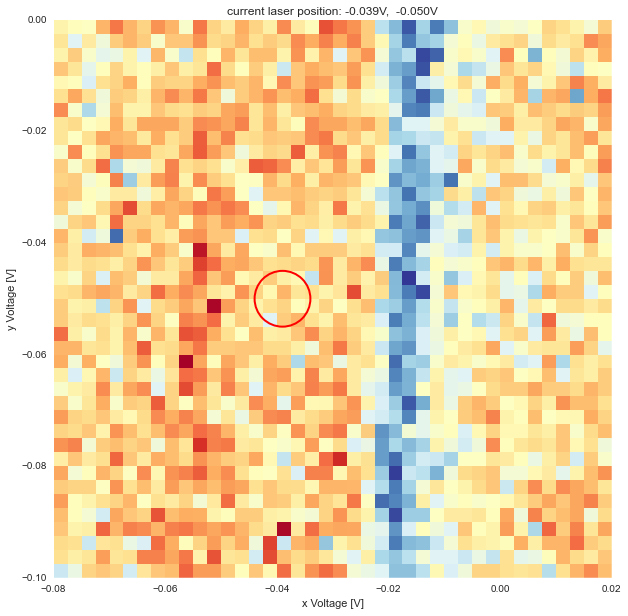

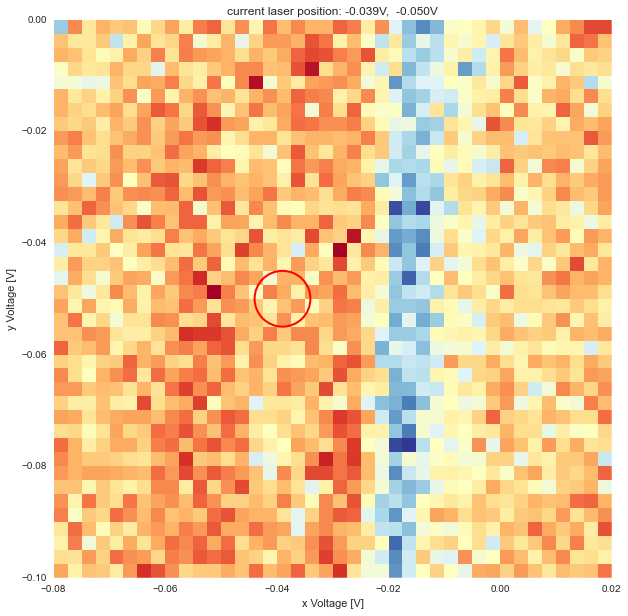

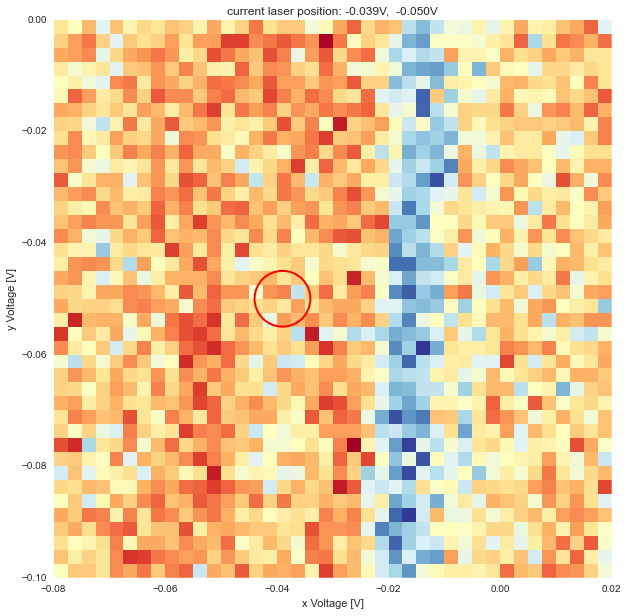

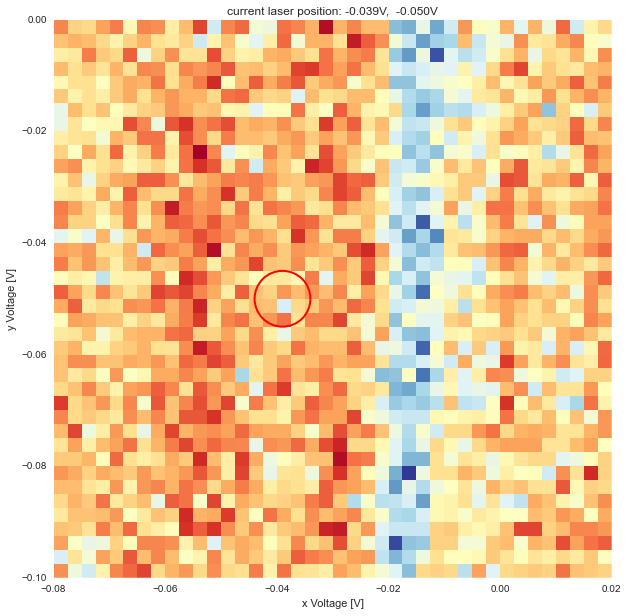

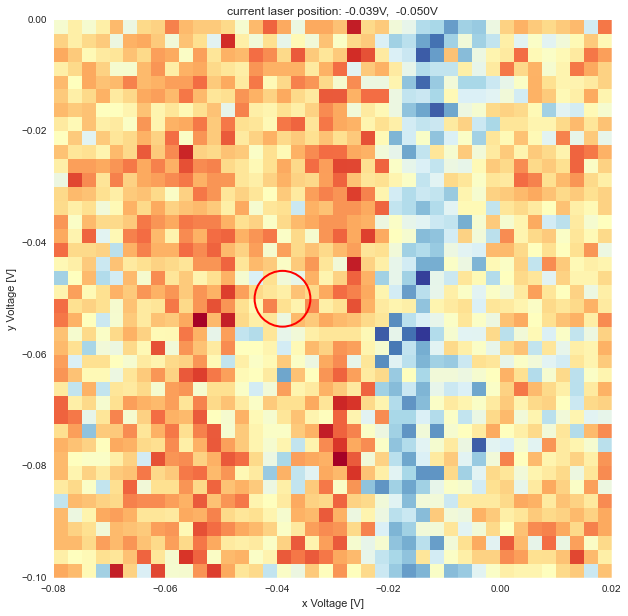

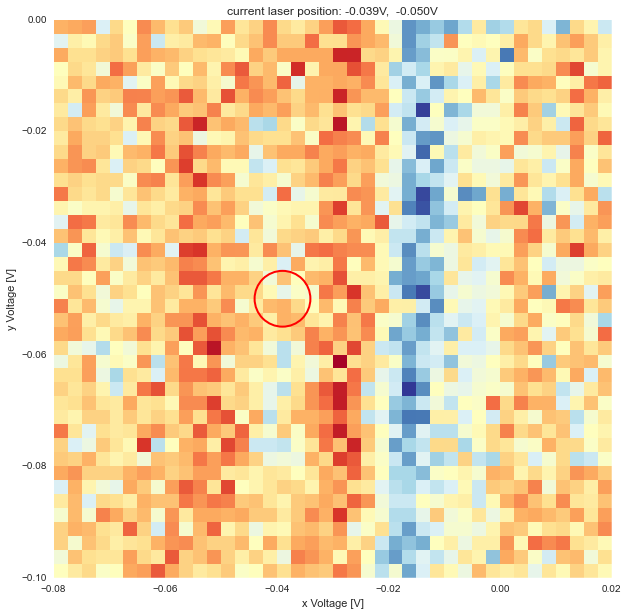

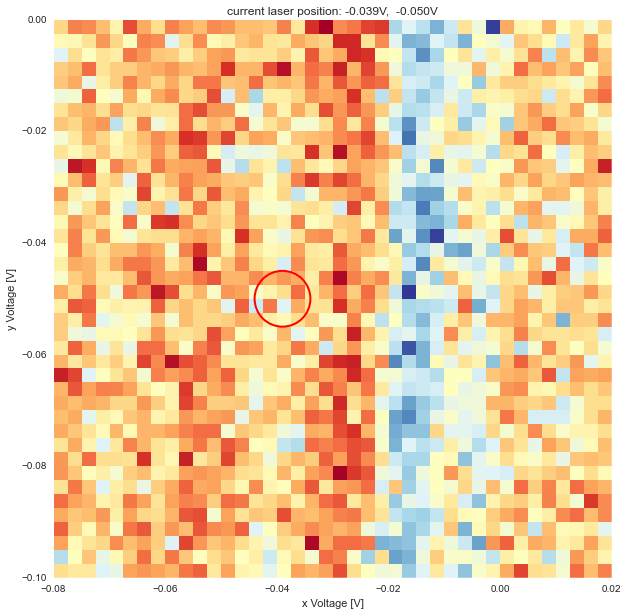

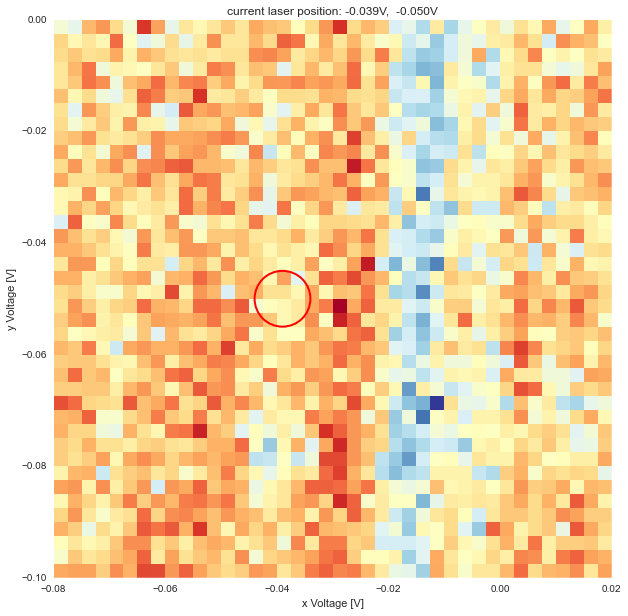

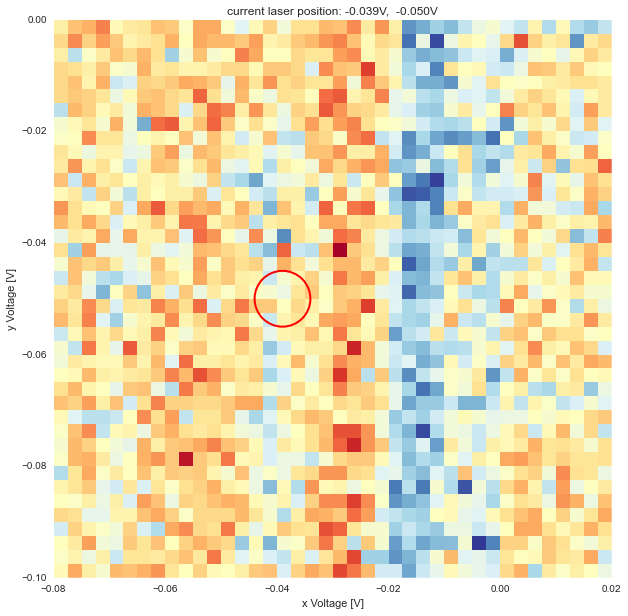

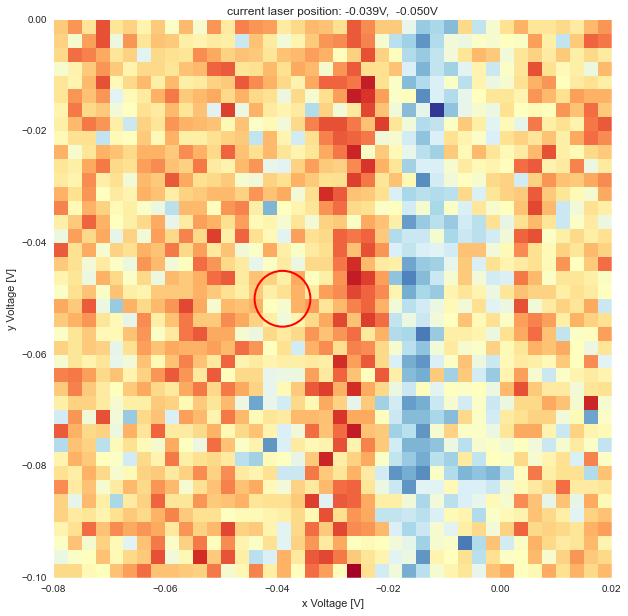

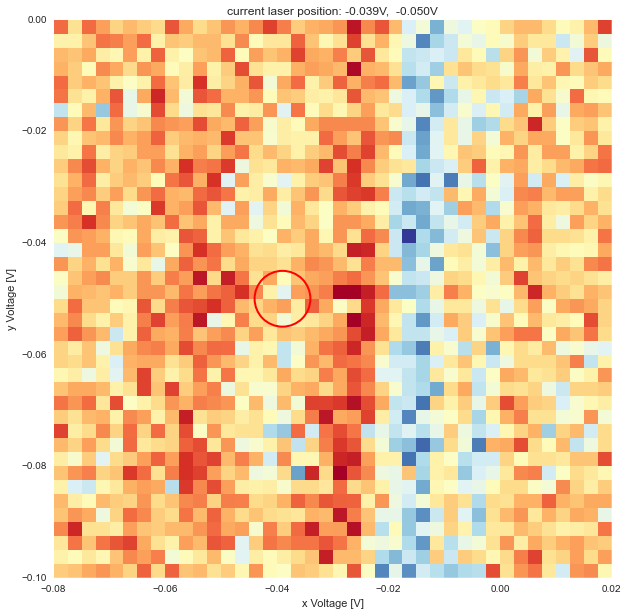

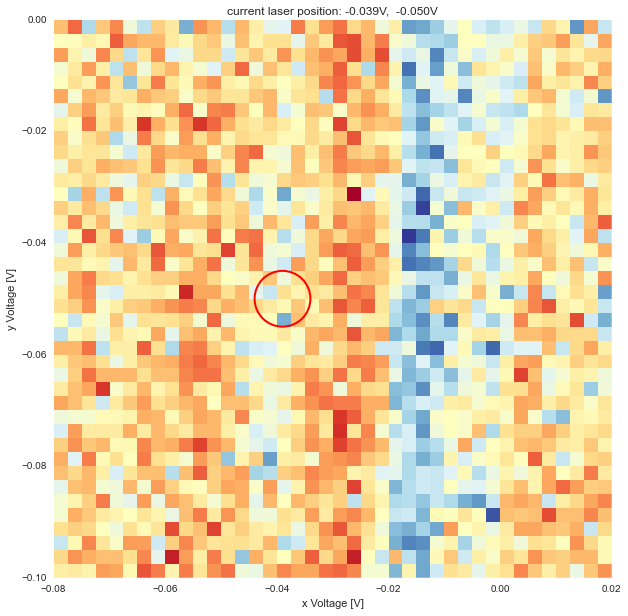

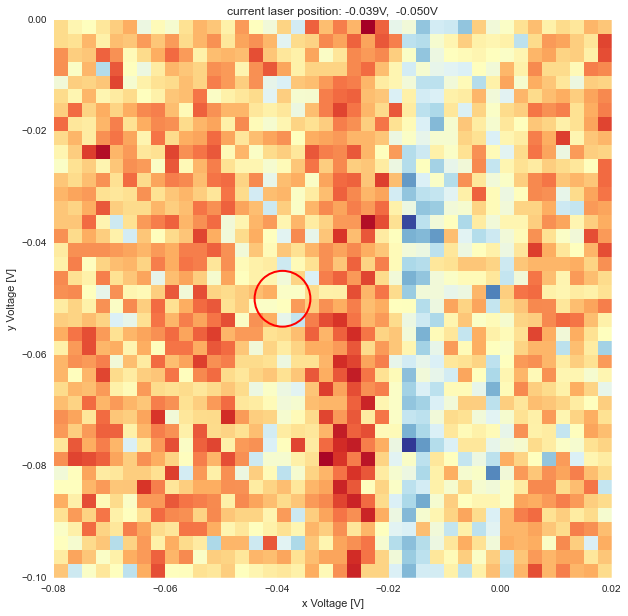

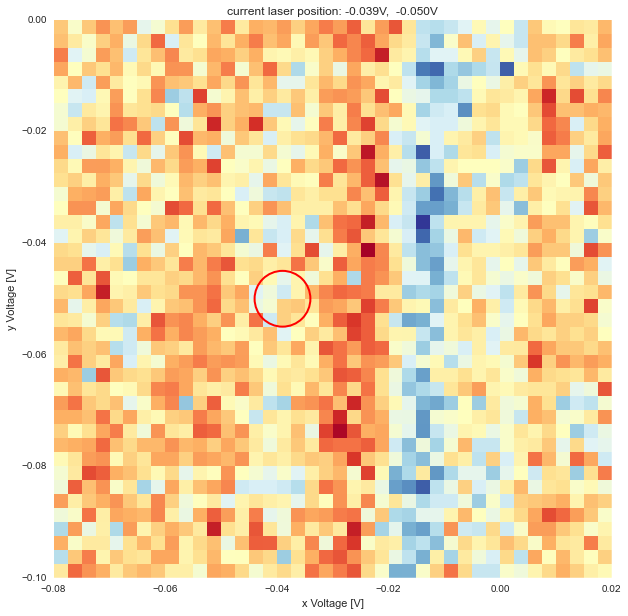

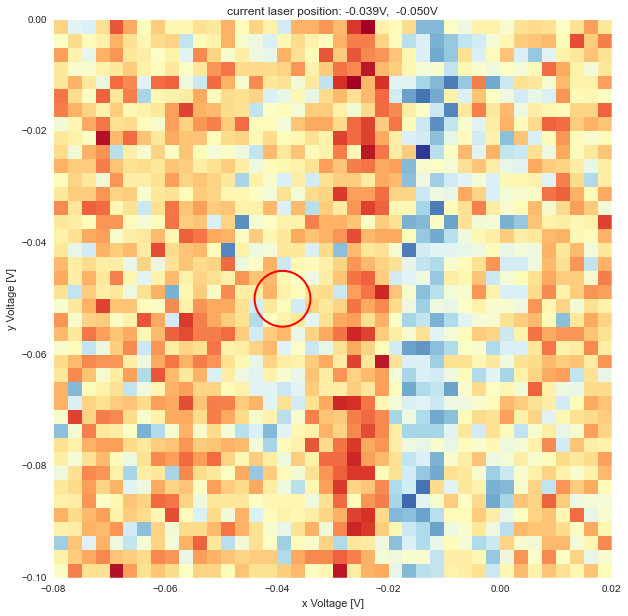

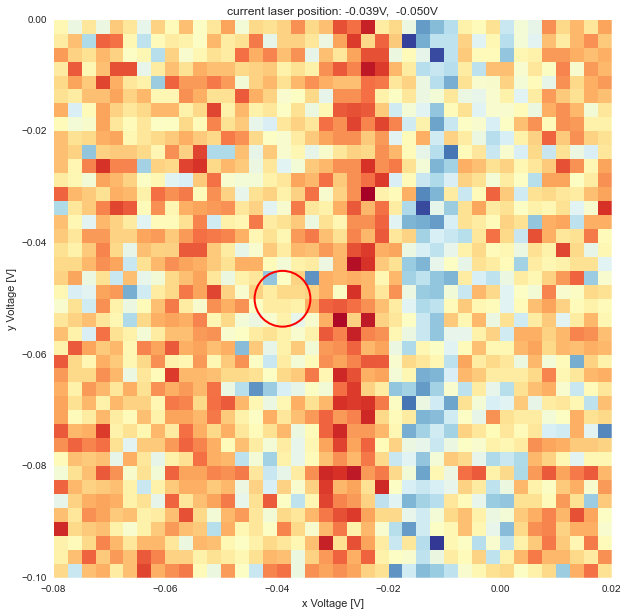

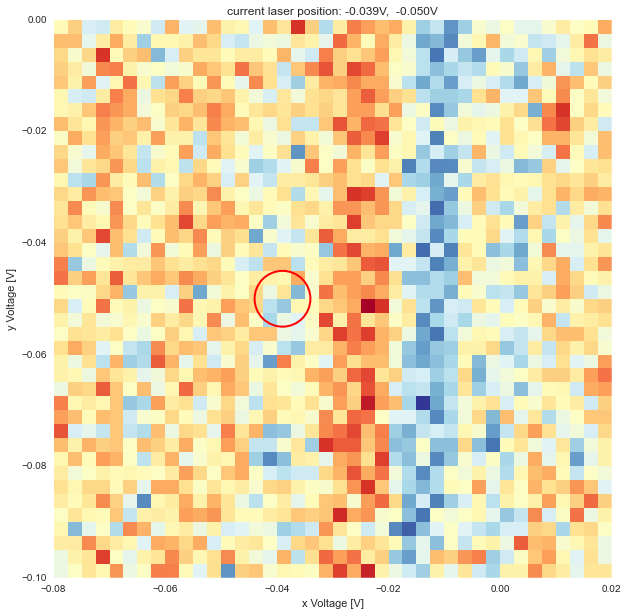

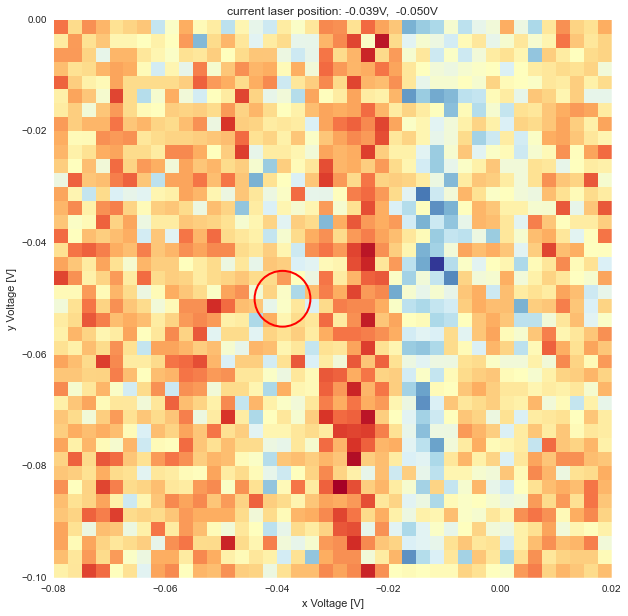

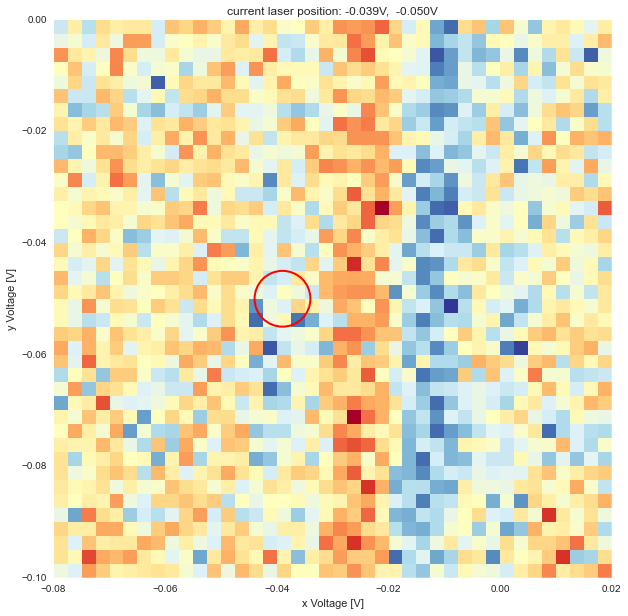

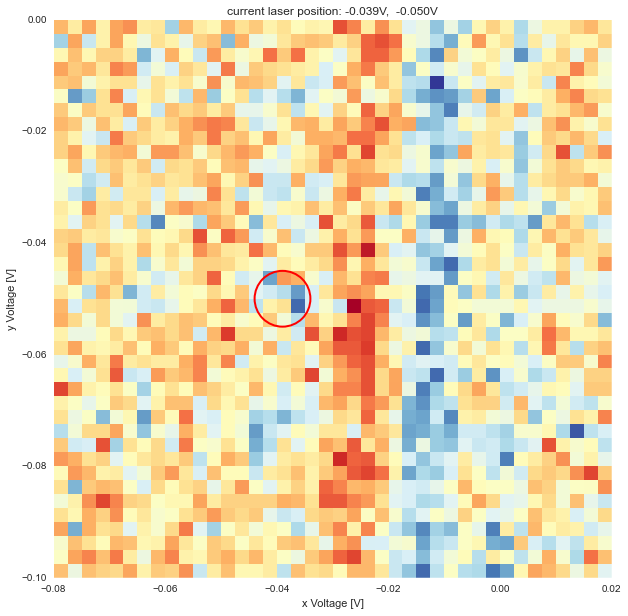

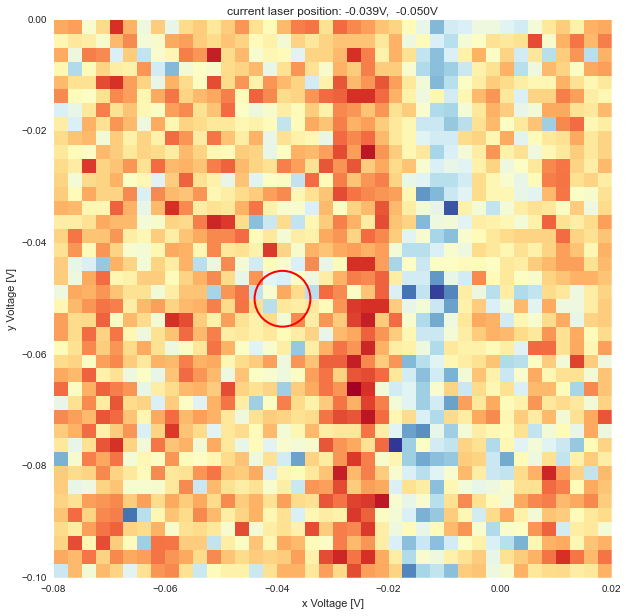

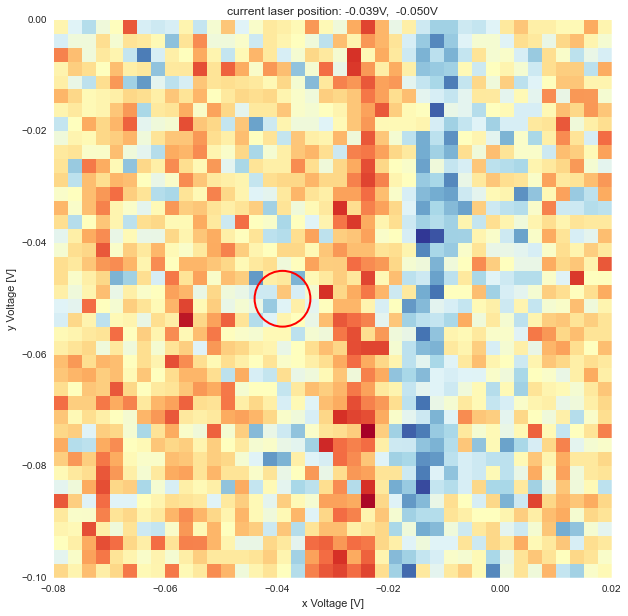

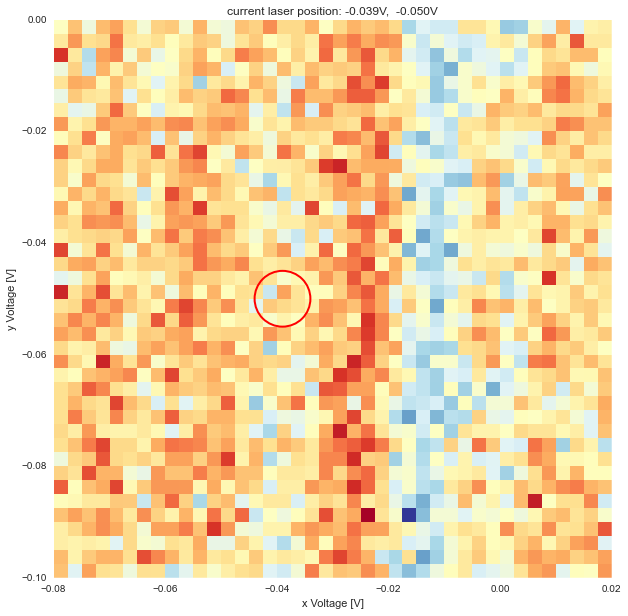

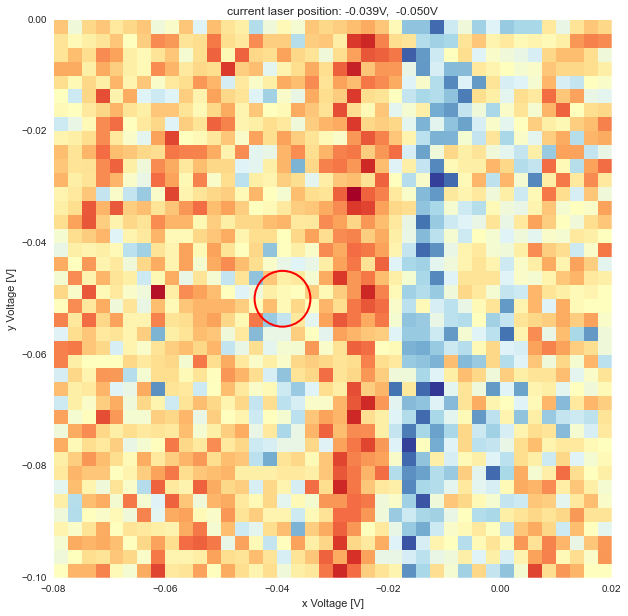

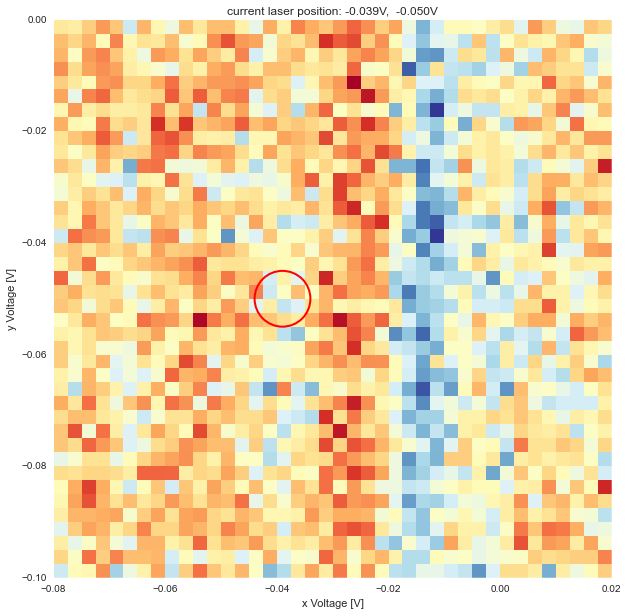

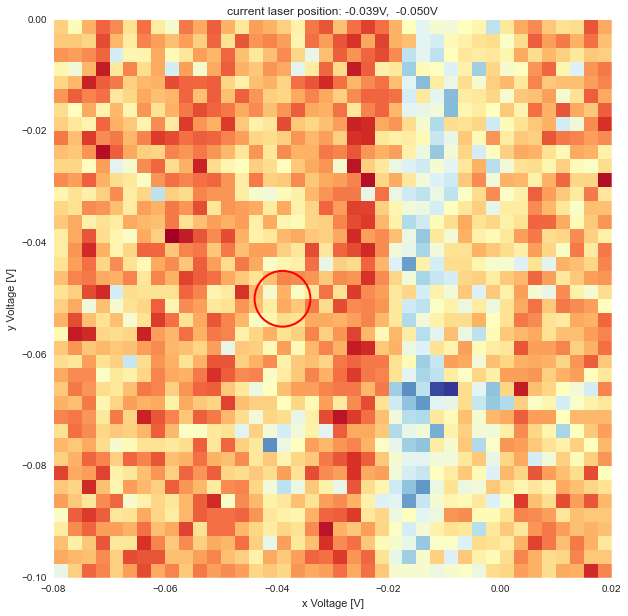

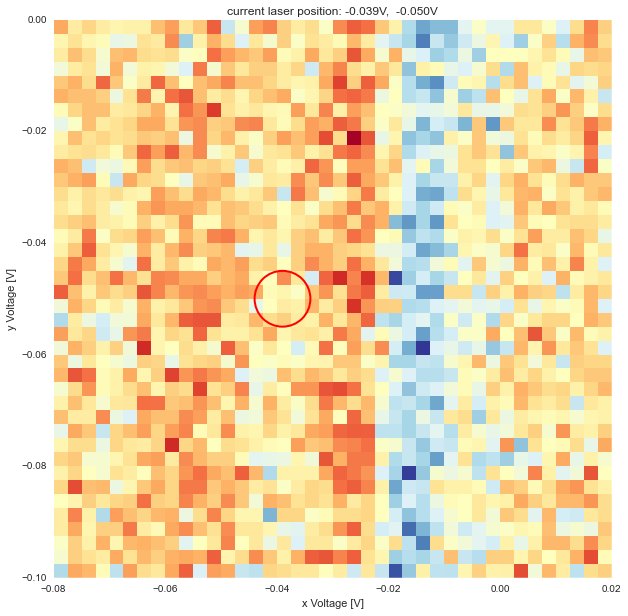

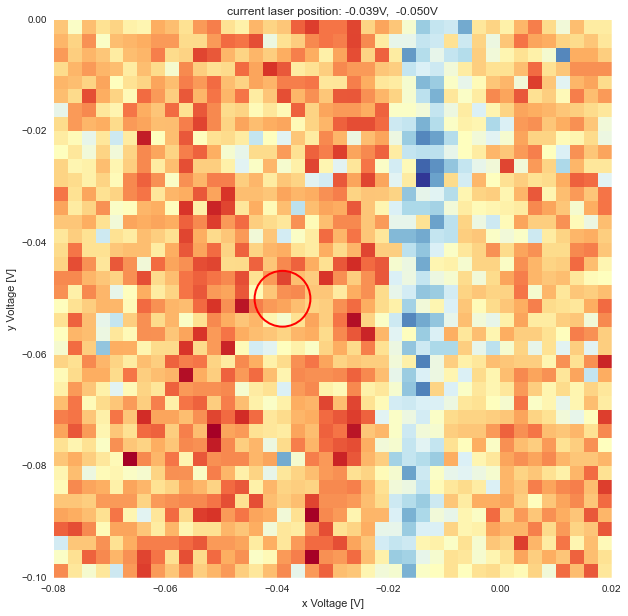

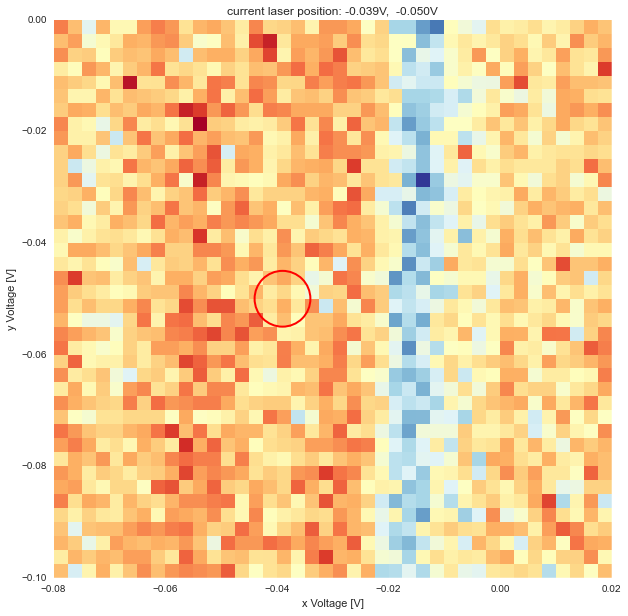

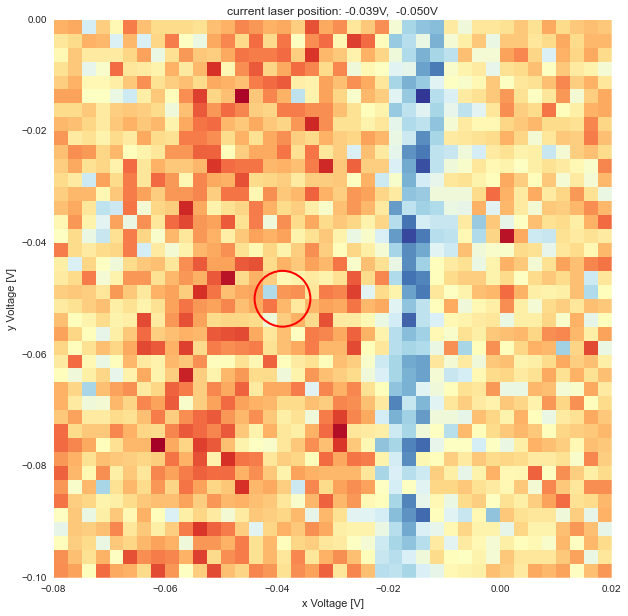

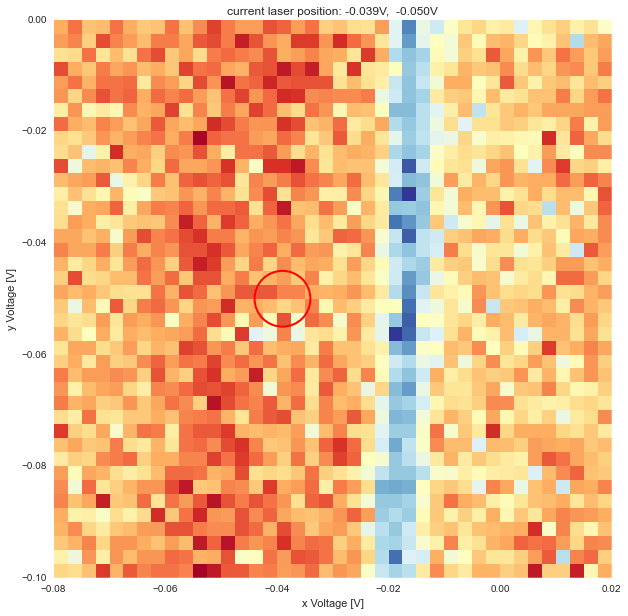

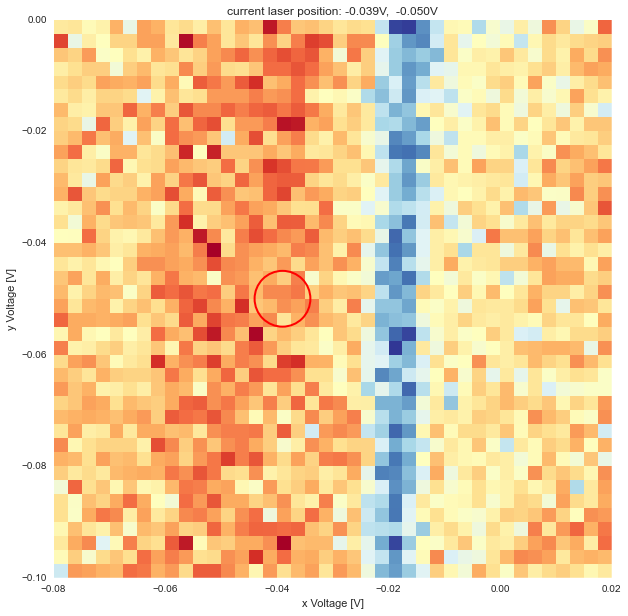

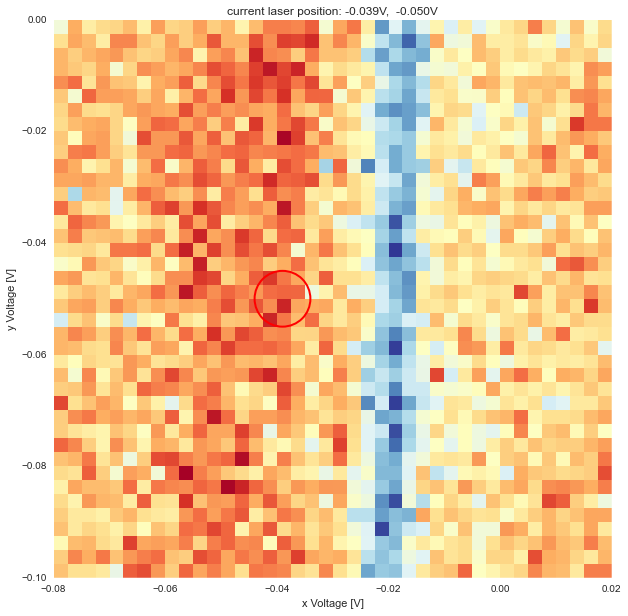

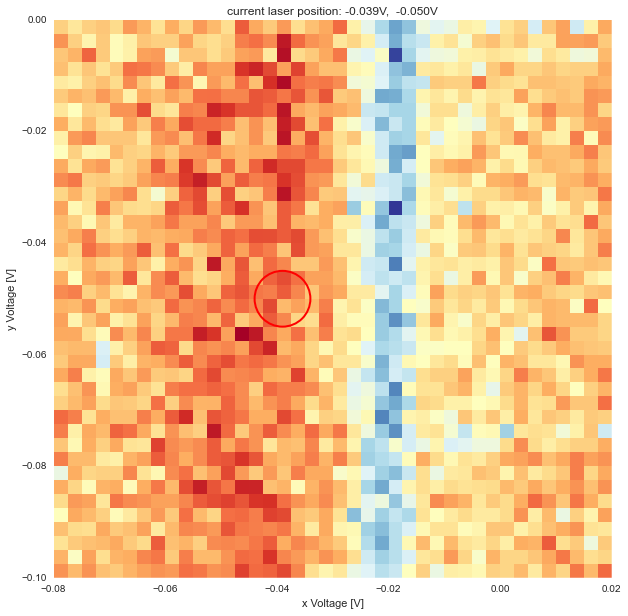

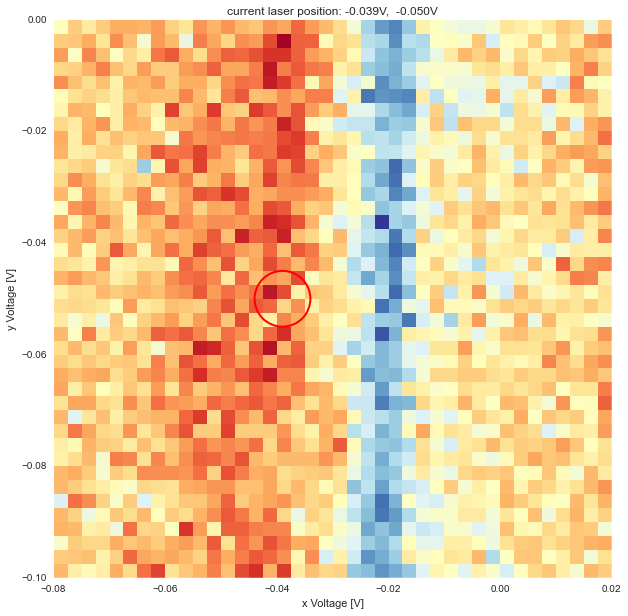

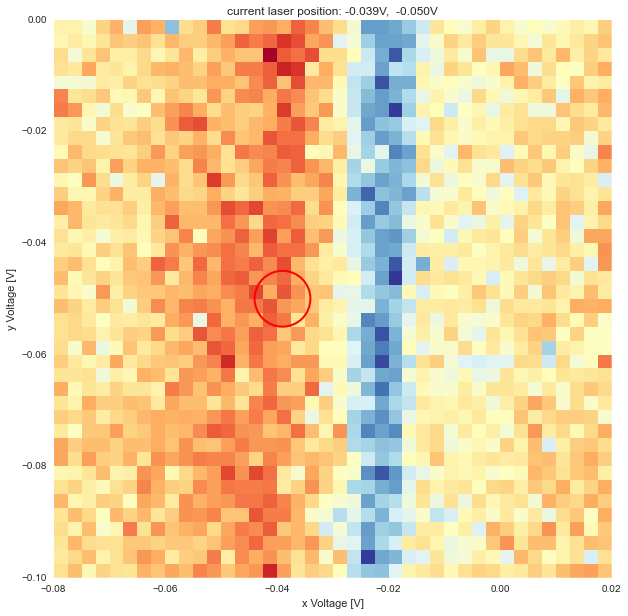

In [122]:


with open('{:s}.sweep'.format('{:s}/{:s}'.format(DIR_PATH, filename)), 'w') as outfile:
    json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


# scan ROI
xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(ROI)

with open('{:s}.roi'.format('{:s}/{:s}'.format(DIR_PATH, filename)), 'w') as outfile:
     json.dump(ROI, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

        
# ========================================================================================
# set laser position
SetGalvoPoint(ROI['x_laser'], ROI['y_laser']) 

        
for i in np.arange(6*10):
    print time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    
    full_filename = '{:s}/{:s}_Fo_{:00.3f}_time_{:s}'.format(DIR_PATH, filename, Fo*1e-3,  current_time)

    scanner = galvo_scan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts, TIME_PER_PT, canvas = None)
    roi_image_data = scanner.scan()

    fig_RoI, axes = plt.subplots(nrows=1, ncols=1, sharey=False);
    display_image(axes, roi_image_data, [xVmin, xVmax, yVmin, yVmax], title='current laser position: {:00.3f}V,  {:00.3f}V'.format(ROI['x_laser'], ROI['y_laser']))

    axes.add_patch(patches.Circle(xy=(ROI['x_laser'], ROI['y_laser']), radius=.005, fill=False, edgecolor='r', linewidth=2))

    fig_RoI.savefig('{:s}.png'.format(full_filename))
    np.savetxt('{:s}.csv'.format(full_filename), roi_image_data, fmt='%.18e', delimiter=',')


    # ========================================================================================
    # look for mechanical resonance and save sweep data

    zi_hf2.sweep(**sweep_parameter)

    zi_hf2.writeData('{:s}.dat'.format(full_filename))
    
    # wait
    time.sleep(7*60)


In [42]:
sweep_parameter

{'direction': 0,
 'freqEnd': 1935500.0,
 'freqStart': 1933500.0,
 'loopcount': 1,
 'sampleNum': 401.0,
 'samplesPerPt': 4,
 'timeout': 100000000.0,
 'xScale': 0}

array([0, 1, 2, 3, 4, 5, 6, 7, 8])